In [16]:
# Sample to be processed
study = 'scmznos_valtor_combined'


In [17]:
# Input/output/resource directories
place = 'nemo'
scratchdir = "/plus/scratch/users/scott/projects/scmznos_valtor"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'
syncdir='/home/scott/Sync/scmznos_sync'


In [18]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import io

import scanpy as sc
import anndata as ad
import pybiomart as pbm
import leidenalg as la
import scrublet as scr

import graphtools as gt
from pygsp import graphs, filters
import phate
import magic
import scprep
import sklearn
import meld

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{syncdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000
mpl.rcParams['pdf.fonttype'] = 42

In [19]:
# Show loaded libraries
import session_info
session_info.show()

### Load DGE functions

In [20]:
from statsmodels.stats.multitest import multipletests
from fisher import pvalue_npy
import numpy as np
import pandas as pd

def OR(adata, cluster_col = 'Subtissue', cluster = 'Integument', eps = 1e-7, correction = 'fdr_bh', return_significant = True, p_threshold = 0.05, OR_cutoff=None, FE_cutoff=None):

    # Binarise expression data
    detection_data = adata.X.copy()
    detection_data.data[detection_data.data != 0] = 1

    # Binarise cluster membership and make 1d matrix
    membership = np.array(adata.obs[cluster_col] == cluster)
    membership_data = np.reshape(membership, (detection_data.shape[0], 1)).astype(int)

    # Calculate contigency table
    tp = np.sum(np.add(membership_data, detection_data.toarray()) == 2, axis=0).astype(np.uint)
    fp = np.sum(np.subtract(detection_data.toarray(), membership_data) == 1, axis=0).astype(np.uint)
    fn = np.sum(np.subtract(membership_data, detection_data.toarray()) == 1, axis=0).astype(np.uint)
    tn = np.sum(np.add(membership_data, detection_data.toarray()) == 0, axis=0).astype(np.uint)

    # Calculate odds ratio
    OR = ((tp + eps) / (fp + eps)) / ((fn + eps) / (tn + eps))
    # OR = np.nan_to_num(OR)

    # Fold enrichment
    FE = ((tp + eps) / (tp + fn + eps)) / ((tp + fp + eps) / (tp + fp + fn + tn + eps))
    
    # Calculate fisher exact t-test
    _, _, twosided = pvalue_npy(tp, fp, fn, tn)

    # Multiple hypothesis test
    _, p_adjusted, _, _ = multipletests(twosided, alpha=0.05, method=correction, is_sorted=False, returnsorted=False)

    # Collate and return results in dataframe
    df = pd.DataFrame({"Cluster":cluster, "TP":tp, "FP":fp, "FN":fn, "TN":tn, "FE":FE, "OR":OR, "logOR":np.log2(OR), "P":twosided, "P_adjust":p_adjusted, 'log10P_adjust':-np.log10(p_adjusted)}, index=adata.var_names)

    # Filter to significant results
    if return_significant:
        df = df[df['P_adjust'] <= p_threshold]
    if OR_cutoff is not None:
        df = df[df['OR'] >= OR_cutoff]
    if FE_cutoff is not None:
        df = df[df['FE'] >= FE_cutoff]

    del detection_data
    del membership_data
    return df.sort_values(by=['logOR'], ascending=[False])


In [21]:
from joblib import Parallel, delayed
# from pyFunctions.utils import OR
import scanpy as sc

def enrichment(adata, clusters, n_jobs=3):

    # Creat results dict
    DG_dict={}
    
    # Odds ratio
    ORs = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(OR)(adata, cluster_col = clusters, cluster = st, eps = 1e-7, correction = 'fdr_bh', return_significant = False)
             for st in adata.obs[clusters].cat.categories.to_list())
    DDGs = {iclust['Cluster'].iloc[0] : iclust for iclust in ORs}
    del ORs
    
    # T-test
    sc.tl.rank_genes_groups(adata, groupby=clusters, use_raw=False, method='t-test_overestim_var', n_genes=None, pts=True)
    
    # Combine results
    for clust in list(DDGs.keys()):
        DDGs[clust]['OR_rank'] = list(range(1, DDGs[clust].shape[0]+1))
        DEGs = sc.get.rank_genes_groups_df(adata, group=clust)
        DEGs['lfc_rank'] = list(range(1, DEGs.shape[0]+1))
        DEGs.index = DEGs.names
        DGs = pd.concat([DDGs[clust], DEGs], axis=1)
        DGs['combined_rank'] = DGs['OR_rank'] + DGs['lfc_rank']
        DGs['both_sig'] = ((DGs['P_adjust'] < 0.05) & (DGs['pvals_adj'] < 0.05))
        DGs['either_sig'] = ((DGs['P_adjust'] < 0.05) | (DGs['pvals_adj'] < 0.05))

        DG_dict[clust] = DGs
        del DEGs

    del DDGs
    
    return DG_dict

### Load whole dataset

In [22]:
# Load preprocessed data
sdata = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_scmznos_valtor_combined_cells_preprocessed_annotated_FINAL.h5ad')
sdata

AnnData object with n_obs × n_vars = 10551 × 19782
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'total_counts_label', 'log1p_total_counts_label', 'pct_counts_label', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_number', 'Detected_any', 'Transplant', 'Transplant_WT', 'Transplant_KO', 'Condition_marker', 'WT_marker', 'KO_marker', 'Host_marker', 'log10_total_counts', 'Condition_SNP', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'E

In [23]:
# Count number of highly variable genes
sdata.var.highly_variable.sum()


6632

In [24]:
# Load preprocessed data
sdata_KO = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_{study}_cells_preprocessed_KOonly.h5ad')
sdata_KO.var.highly_variable.sum()

6424

In [25]:
# Create a list of HVGs in either all genes or KO only
sdata.var['hvg_any'] = sdata.var.index.isin(sdata_KO.var.index[sdata_KO.var.highly_variable].to_list()) | sdata.var.highly_variable
sdata.var['hvg_any'].sum()


8936

### Load MZT annotations

In [26]:
# Add NPS bound annotation from Liyun
NPS_open_5kb = pd.read_csv(f"{commonsdir}/gene_lists/N_P_S_cobound_open_5kb_genes.txt", delimiter='\t', header=None, names=['Chromosome', 'Start', 'End', 'gene'], index_col=False)
sdata.var['NPS_open_5kb'] = sdata.var.EnsemblID.isin(NPS_open_5kb['gene'].to_list())


/tmp/ipykernel_2160403/1626902061.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  NPS_open_5kb = pd.read_csv(f"{commonsdir}/gene_lists/N_P_S_cobound_open_5kb_genes.txt", delimiter='\t', header=None, names=['Chromosome', 'Start', 'End', 'gene'], index_col=False)


In [27]:
# Annotate genes with mir430 binding information
GTF = pd.read_csv(f'{datadir}/GRCz11_104_3_prime_UTR.csv')
sdata.var['mir430_seed'] = sdata.var.EnsemblID.isin(GTF[GTF.mir430_motif_seed].gene_id)


/tmp/ipykernel_2160403/1650237759.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  GTF = pd.read_csv(f'{datadir}/GRCz11_104_3_prime_UTR.csv')


In [28]:
# Load and annotate Amaral annotations
MZT_Amaral = pd.read_csv(f'{commonsdir}/gene_lists/20240912_MZT_gene_annotation_Amaral_2024.csv', index_col=0)[['mzt_gene_class', 'target']]
sdata.var['strictly_maternal_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal'])].index.to_list())
sdata.var['maternal_zygotic_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal_zygotic'])].index.to_list())
sdata.var['strictly_zygotic_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['zygotic'])].index.to_list())
sdata.var['total_maternal_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal', 'maternal_zygotic'])].index.to_list())
sdata.var['activated_late_Amaral'] = ~(sdata.var['total_maternal_Amaral'] | sdata.var['strictly_zygotic_Amaral'])
sdata.var['mir430_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.target.str.contains('target')].index.to_list())
sdata.var['total_mir430_Amaral'] = sdata.var['mir430_Amaral'] | sdata.var['mir430_seed']

MZT_lists = ['NPS_open_5kb',
             'strictly_maternal_Amaral',
             'maternal_zygotic_Amaral',
             'strictly_zygotic_Amaral',
             'total_mir430_Amaral']

In [30]:
sdata.var.loc[:,MZT_lists].sum()

NPS_open_5kb                4215
strictly_maternal_Amaral    3376
maternal_zygotic_Amaral     4767
strictly_zygotic_Amaral      811
total_mir430_Amaral         5718
dtype: int64

In [31]:
sdata.obs.to_csv(f'{scratchdir}/preprocessed_data/Obs_expression_{study}_cells_preprocessed_annotated_MZT.csv')
sdata.var.to_csv(f'{scratchdir}/preprocessed_data/Var_expression_{study}_cells_preprocessed_annotated_MZT.csv')


### Visualise marker expression in bulk temporal data

In [15]:
# Load preprocessed data
sdata_bulk = sc.read_h5ad(f'/plus/scratch/users/scott/projects/mznps_timecourse/preprocessed_data/Anndata_mznps_timecourse_cells_preprocessed.h5ad')
sdata_bulk

AnnData object with n_obs × n_vars = 232 × 31901
    obs: 'Sample_id', 'Condition', 'Replicate', 'Timepoint', 'Sample_type', 'hpf', 'Batch', 'Library_size', 'Normalisation_factor'
    var: 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype'
    layers: 'X_normalised', 'X_preNorm'

In [16]:
# Subset to NP and WT from Batch B
sdata_bulk = sdata_bulk[(sdata_bulk.obs.Condition.isin(['MZnps', 'WT']) & (sdata_bulk.obs.Batch == 'B'))]
sdata_bulk

View of AnnData object with n_obs × n_vars = 70 × 31901
    obs: 'Sample_id', 'Condition', 'Replicate', 'Timepoint', 'Sample_type', 'hpf', 'Batch', 'Library_size', 'Normalisation_factor'
    var: 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype'
    layers: 'X_normalised', 'X_preNorm'

In [17]:
sdata_bulk.obs

Sample_id Condition Replicate Timepoint  \
MZnps_rep1_6hpf      MZnps_rep1_6hpf     MZnps      rep1      6hpf   
MZnps_rep1_5.5hpf  MZnps_rep1_5.5hpf     MZnps      rep1    5.5hpf   
MZnps_rep1_5hpf      MZnps_rep1_5hpf     MZnps      rep1      5hpf   
MZnps_rep1_4.5hpf  MZnps_rep1_4.5hpf     MZnps      rep1    4.5hpf   
MZnps_rep1_4hpf      MZnps_rep1_4hpf     MZnps      rep1      4hpf   
...                              ...       ...       ...       ...   
WT_rep11_4.5hpf      WT_rep11_4.5hpf        WT     rep11    4.5hpf   
WT_rep11_4hpf          WT_rep11_4hpf        WT     rep11      4hpf   
WT_rep11_3.5hpf      WT_rep11_3.5hpf        WT     rep11    3.5hpf   
WT_rep11_3hpf          WT_rep11_3hpf        WT     rep11      3hpf   
WT_rep11_2.5hpf      WT_rep11_2.5hpf        WT     rep11    2.5hpf   

                    Sample_type  hpf Batch  Library_size  Normalisation_factor  
MZnps_rep1_6hpf      MZnps_6hpf  6.0     B      17282015              0.956149  
MZnps_rep1_5.5hpf  MZnps_5.5hpf  5.5     B      17693681              0.926691  
MZnps_rep1_5hpf      MZnps_5hpf  5.0     B      16541096              0.985346  
MZnps_rep1_4.5hpf  MZnps_4.5hpf  4.5     B      15791157              0.991746  
MZnps_rep1_4hpf      MZnps_4hpf  4.0     B      14686877              1.033522  
...                         ...  ...   ...           ...                   ...  
WT_rep11_4.5hpf       WT_4.5hpf  4.5     B      17093157              0.936199  
WT_rep11_4hpf           WT_4hpf  4.0     B      15172536              0.984850  
WT_rep11_3.5hpf       WT_3.5hpf  3.5     B      14315022              1.004924  
WT_rep11_3hpf           WT_3hpf  3.0     B      14492287              0.993477  
WT_rep11_2.5hpf       WT_2.5hpf  2.5     B      15119441              0.952749  

[70 rows x 9 columns]

In [18]:
# # Filter to genes that are found in at least 2 samples from either condition 
# min_counts = 0
# for i in sdata_bulk.obs.Condition.unique():
#     sdata_bulk.var[f'Detection_{i}'] = list((sdata_bulk[sdata_bulk.obs['Condition'] == i].X > min_counts).astype(int).sum(axis=0))


In [19]:
# # Identify genes missing from bulk dataset
# missing_list = sdata.var[sdata.var['hvg_any']].index[~(sdata.var[sdata.var['hvg_any']].index.isin(sdata_bulk.var.index.to_list()))].to_list()
# for i in missing_list:
#     E_id = sdata.var.loc[i]['gene_ids']
#     if sum(sdata_bulk.var.gene_id == E_id) < 1: continue
#     j = sdata_bulk.var[sdata_bulk.var.gene_id == E_id].index[0]
#     sdata_bulk.var.rename(index={j:i}, inplace=True)

In [20]:
# Filter to transcripts detected (>=1 CPM) in at least 2 replicates of a given sample type or at least 5 samples overall
min_counts = 0
for i in sdata_bulk.obs.Condition.unique():
    sdata_bulk.var[f'Detection_{i}'] = list((sdata_bulk[sdata_bulk.obs['Condition'] == i].X > min_counts).astype(int).sum(axis=0))

sdata_bulk.var['Keep_filter'] = ((sdata_bulk.var.loc[:,sdata_bulk.var.columns.str.contains('Detection')] >= 2).sum(axis=1) != 0)
sdata_bulk = sdata_bulk[:,sdata_bulk.var['Keep_filter']]
sdata_bulk

/tmp/ipykernel_755823/455995837.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  sdata_bulk.var[f'Detection_{i}'] = list((sdata_bulk[sdata_bulk.obs['Condition'] == i].X > min_counts).astype(int).sum(axis=0))


View of AnnData object with n_obs × n_vars = 70 × 26039
    obs: 'Sample_id', 'Condition', 'Replicate', 'Timepoint', 'Sample_type', 'hpf', 'Batch', 'Library_size', 'Normalisation_factor'
    var: 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'Detection_MZnps', 'Detection_WT', 'Keep_filter'
    layers: 'X_normalised', 'X_preNorm'

In [21]:
# Rename wnt 4 to wnt4a for compatability
sdata_bulk.var.rename(index={'wnt4':'wnt4a'}, inplace=True)
sdata_bulk.var.rename(index={'CU855930.2':'CU855930.1'}, inplace=True)
sdata_bulk.var.rename(index={'GADD45G':'BX530077.1'}, inplace=True)
sdata_bulk.var.rename(index={'akr1b1.2':'si:dkey-180p18.9'}, inplace=True)
sdata_bulk.var.rename(index={'zgc:77118-1':'zgc:77118'}, inplace=True)


In [22]:
# Scale expression values
sdata_bulk.raw = sdata_bulk.copy()
sc.pp.scale(sdata_bulk, copy = False)
sdata_bulk.X = scipy.sparse.csr_matrix(sdata_bulk.X)
sdata_bulk.layers["X_scaled"] = sdata_bulk.X
sdata_bulk.X = sdata_bulk.layers["X_normalised"]


In [23]:
# Calculate mean of scaled values for DEGs
sdata_bulk.X = sdata_bulk.layers["X_scaled"]
sdata_bulk.obs['Sample_type'] = sdata_bulk.obs['Sample_type'].cat.reorder_categories(['WT_2.5hpf', 'WT_3hpf', 'WT_3.5hpf', 'WT_4hpf', 'WT_4.5hpf', 'WT_5hpf', 'WT_5.5hpf', 'WT_6hpf','MZnps_2.5hpf', 'MZnps_3hpf', 'MZnps_3.5hpf', 'MZnps_4hpf', 'MZnps_4.5hpf', 'MZnps_5hpf', 'MZnps_5.5hpf',  'MZnps_6hpf'])

bulk_mean = sdata_bulk[:,sdata_bulk.var.index.isin(sdata.var[sdata.var['hvg_any']].index.to_list())].to_df().groupby(sdata_bulk.obs.Sample_type).mean()
bulk_mean

/tmp/ipykernel_755823/1300377284.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bulk_mean = sdata_bulk[:,sdata_bulk.var.index.isin(sdata.var[sdata.var['hvg_any']].index.to_list())].to_df().groupby(sdata_bulk.obs.Sample_type).mean()


slc35a5      nrf1     ube2h  slc9a3r1a       dap     thraa  \
Sample_type                                                                 
WT_2.5hpf     0.911623  0.616954  1.023572   1.053240  1.579879  1.076666   
WT_3hpf       1.096131  0.312282  0.792387   1.117808  0.614553  0.997601   
WT_3.5hpf     1.023327  0.480186  0.824414   0.788157 -0.291364  0.647517   
WT_4hpf       0.603371  0.529798  0.886778   0.786378 -0.400948 -0.104492   
WT_4.5hpf    -0.065934 -0.193968  0.832804   0.416160 -0.278878 -0.590540   
WT_5hpf      -0.938725 -0.551330  0.170295   0.110926 -0.150281 -1.060151   
WT_5.5hpf    -1.371468 -0.463491 -1.044615   0.004818 -0.403142 -1.291541   
WT_6hpf      -1.708944 -0.843025 -2.038250  -0.099954 -0.905285 -1.456930   
MZnps_2.5hpf  0.653180 -0.291366 -0.121182  -0.003314  2.673727  0.953983   
MZnps_3hpf    0.954411 -0.133413 -0.116364  -0.296205  1.077935  1.262566   
MZnps_3.5hpf  0.917062  0.183449 -0.159261  -0.321996  0.535108  1.386082   
MZnps_4hpf    0.460072  0.372502 -0.313412  -0.541816 -0.443075  1.157032   
MZnps_4.5hpf  0.166455  0.314280 -0.173779  -1.165010  0.012934  0.667343   
MZnps_5hpf   -0.254089  0.221029 -0.243401  -1.468102 -0.644948  0.014452   
MZnps_5.5hpf -0.702505 -0.239293 -0.509659  -2.041676 -0.821823 -0.555455   
MZnps_6hpf   -0.771745 -0.093469 -0.956915  -2.166971 -0.501058 -0.645381   

                itsn2a    hoxb2a     krt97   slc40a1  ...  CABZ01114053.1  \
Sample_type                                           ...                   
WT_2.5hpf     0.598541  0.111299 -0.690146 -0.913157  ...       -1.384322   
WT_3hpf       0.824508  0.043535 -0.669344 -0.967302  ...       -1.221274   
WT_3.5hpf     0.182345 -0.004341 -0.595798 -0.879305  ...       -0.571931   
WT_4hpf      -0.094394 -0.149376 -0.371760 -0.728365  ...        0.181660   
WT_4.5hpf    -0.217669 -0.460397  0.055780 -0.556634  ...        0.964040   
WT_5hpf      -0.662816 -0.851621  0.806610 -0.298660  ...        0.847987   
WT_5.5hpf    -0.563987 -1.130280  1.554635 -0.186050  ...        0.585875   
WT_6hpf      -0.544947 -1.302703  2.276046  0.098864  ...        0.244888   
MZnps_2.5hpf  0.439887  1.380743 -0.683344  0.298533  ...       -1.074833   
MZnps_3hpf    0.179145  1.814160 -0.679278  0.312216  ...       -1.548878   
MZnps_3.5hpf -0.251724  1.803962 -0.667651  0.478848  ...       -0.747563   
MZnps_4hpf   -0.458820  1.547282 -0.662169  0.578714  ...       -0.084385   
MZnps_4.5hpf  0.164008  0.988487 -0.661821  1.210385  ...        0.745838   
MZnps_5hpf    0.869401  0.551892 -0.646205  1.340358  ...        0.952406   
MZnps_5.5hpf  0.743582 -0.053131 -0.627514  2.029444  ...        1.132754   
MZnps_6hpf   -0.382498 -0.048279 -0.561893  2.407845  ...        0.511095   

              zgc:162962    nanos2     park7  BX005085.7      CKS2  \
Sample_type                                                          
WT_2.5hpf      -0.274415  0.283812  0.675909    0.360459  0.791406   
WT_3hpf        -0.274415  0.484031  0.930591    0.361962  0.831149   
WT_3.5hpf      -0.274415 -0.079378  0.806256    0.313806  0.655592   
WT_4hpf        -0.274415  0.480215  0.161709    0.101223 -0.156289   
WT_4.5hpf       0.409702 -0.225784 -0.514544   -0.277173 -0.875859   
WT_5hpf         0.381644 -0.577328 -1.132662   -0.978823 -1.288306   
WT_5.5hpf      -0.274415 -0.577328 -1.499409   -0.918020 -1.467746   
WT_6hpf         0.270306 -0.577328 -1.807339   -0.929509 -1.482659   
MZnps_2.5hpf   -0.274415  0.466528  0.321043    0.441941  0.279475   
MZnps_3hpf     -0.274415  0.127669  0.539823    0.016972  0.611152   
MZnps_3.5hpf   -0.274415 -0.577328  0.972905    0.850991  0.865379   
MZnps_4hpf      1.091375  1.559994  1.085504    1.086613  0.842846   
MZnps_4.5hpf   -0.274415  1.103210  0.928222    0.760269  0.929666   
MZnps_5hpf     -0.274415 -0.577328  0.726008    0.202717  0.871728   
MZnps_5.5hpf   -0.274415 -0.577328  0.285464   -0.366729  0.931843   
MZnps_6hpf      0.993017  0.302872  0.232327    1.2

In [24]:
# Calculate gene clusters
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations = bulk_mean.corr()
correlations_array = np.asarray(bulk_mean.corr())
row_linkage = hierarchy.linkage(distance.pdist(correlations_array), method='ward', optimal_ordering=False)


In [25]:
# Extract cluster from clustering
from scipy.cluster.hierarchy import linkage, cut_tree

cut_height = 200
clusters = pd.DataFrame(cut_tree(row_linkage,
                                 # height=cut_height)
                                 n_clusters = 9)
                        , columns=['Cluster'], index=bulk_mean.columns.to_list())
clusters['Cluster'].value_counts()

Cluster
0    1661
5    1131
8    1054
4     831
7     802
1     796
6     637
3     625
2     498
Name: count, dtype: int64

In [26]:
# Map color to clusters
import matplotlib.pyplot as plt
import matplotlib as mpl

# Number opf colours needed
n_cols = len(clusters['Cluster'].unique())

# # Get a list of colormap names
# cmap_names = plt.colormaps()

# Access a specific colormap
cmap = plt.get_cmap('Spectral')

# Get a list of colors from the colormap
colors = cmap(np.linspace(0, 1, n_cols))  # Get colormap
hex_colors = [mpl.colors.to_hex(color) for color in colors]

# Map colours to clusters
lut = dict(zip(clusters['Cluster'].unique(), hex_colors))
row_colors = clusters['Cluster'].map(lut)
row_colors


slc35a5       #9e0142
nrf1          #dd4a4c
ube2h         #dd4a4c
slc9a3r1a     #f98e52
dap           #9e0142
               ...   
CKS2          #fed481
BX936439.1    #d6ee9b
cst14b.1      #ffffbe
notum1b       #3d95b8
znf1114       #ffffbe
Name: Cluster, Length: 8035, dtype: object

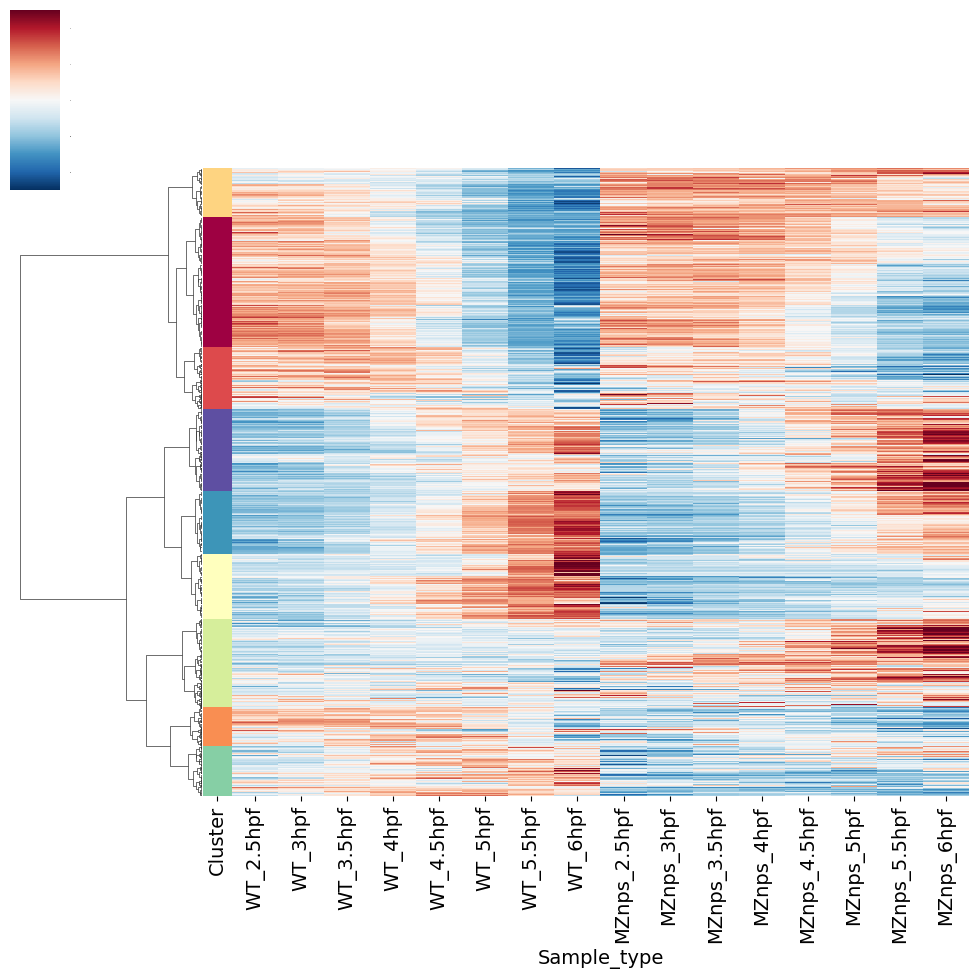

In [27]:
# PLot heatmap of 
ax = sns.clustermap(bulk_mean.T, row_linkage=row_linkage, col_cluster=False, row_cluster=True, row_colors=row_colors, cmap='RdBu_r', vmin=-2.5, vmax=2.5, yticklabels=False)
ax.tick_params(axis='y', labelsize=0.1, right=False, which='both')
# plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_genes_no_labels.pdf')
plt.show()


In [28]:
# # PLot heatmap of 
# ax = sns.clustermap(bulk_mean.T, figsize=(8.27, 500), row_linkage=row_linkage, col_cluster=False, row_cluster=True, row_colors=row_colors, cmap='RdBu_r', vmin=-2.5, vmax=2.5, yticklabels=True)
# ax.cax.set_visible(False)
# ax.tick_params(axis='y', labelsize=0.1, right=False, which='both')
# plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_genes.pdf')
# plt.show()


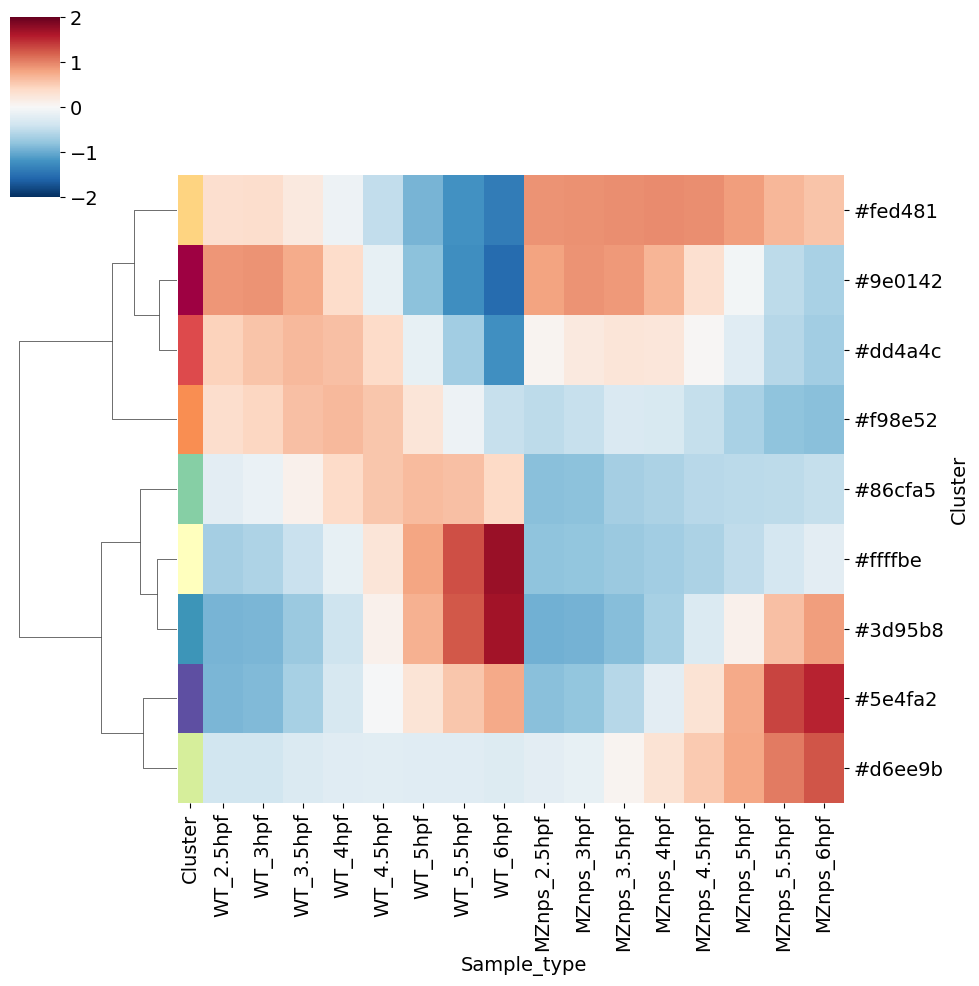

In [29]:
# Create line plots per cluster (basis here - mean of scaled counts per group)
trends = bulk_mean.T.groupby(row_colors).median()
correlations = trends.T.corr()
correlations_array = np.asarray(trends.T.corr())
row_linkage = hierarchy.linkage(distance.pdist(correlations_array), method='ward', optimal_ordering=True)

colours = trends.reset_index()['Cluster']
colours.index = colours

clustermap = sns.clustermap(trends, cmap='RdBu_r', vmin=-2, vmax=2, row_linkage=row_linkage, row_cluster=True, col_cluster=False, row_colors=colours, yticklabels=True)
plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_trends.pdf')


In [30]:
# Extract cluster order
cluster_order = [t.get_text() for t in clustermap.ax_heatmap.yaxis.get_majorticklabels()]
cluster_order
with open(f'{outdir}/HVG_cluster_order.pkl', 'wb') as f:
    pickle.dump(cluster_order, f)

#fed481


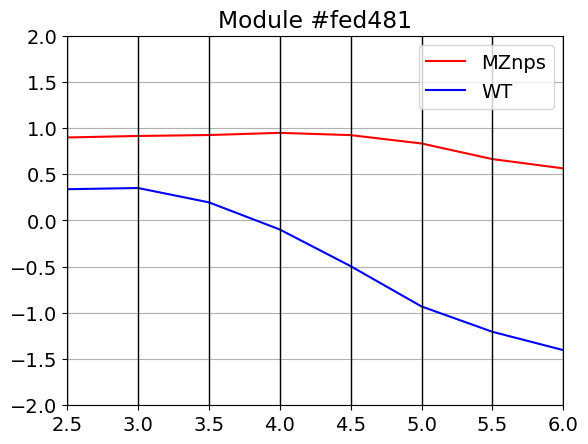

#9e0142


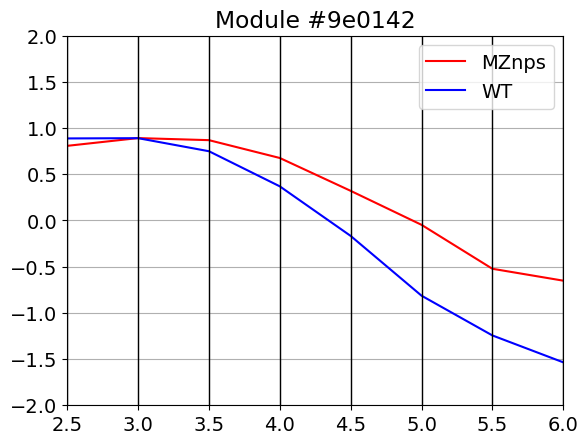

#dd4a4c


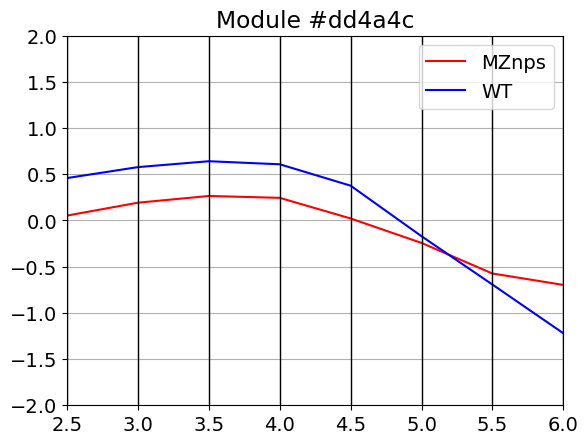

#f98e52


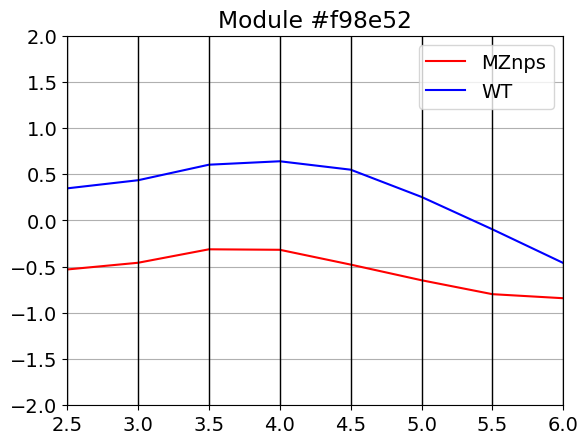

#86cfa5


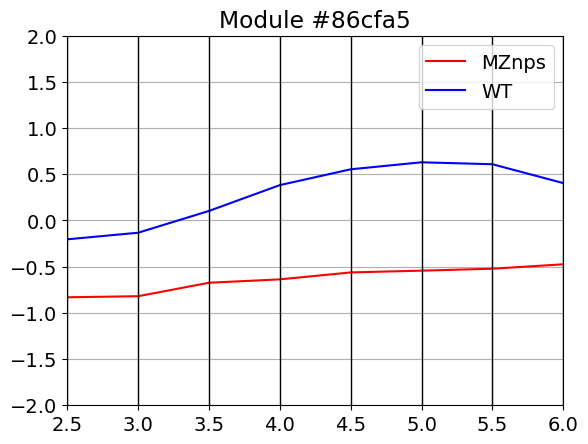

#ffffbe


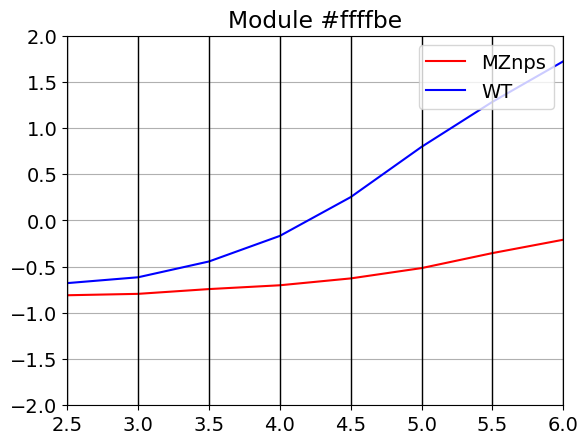

#3d95b8


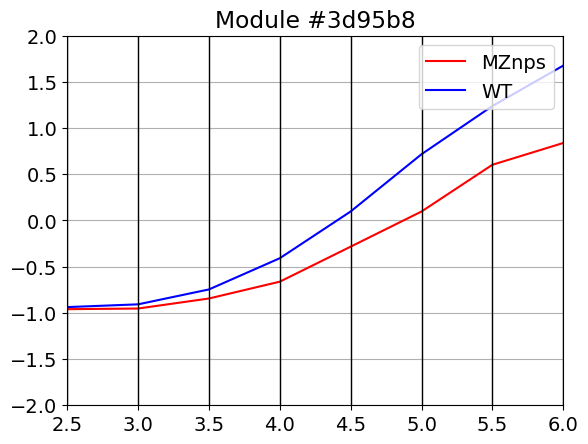

#5e4fa2


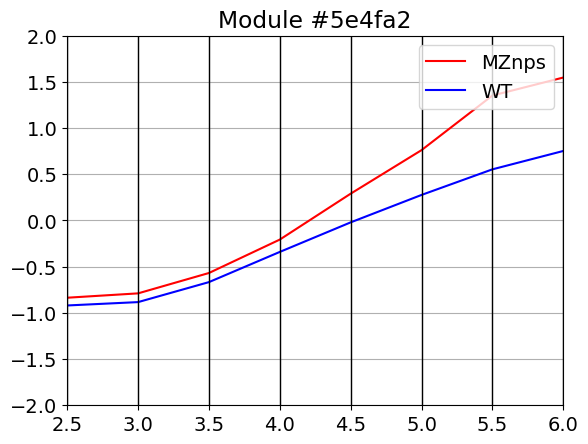

#d6ee9b


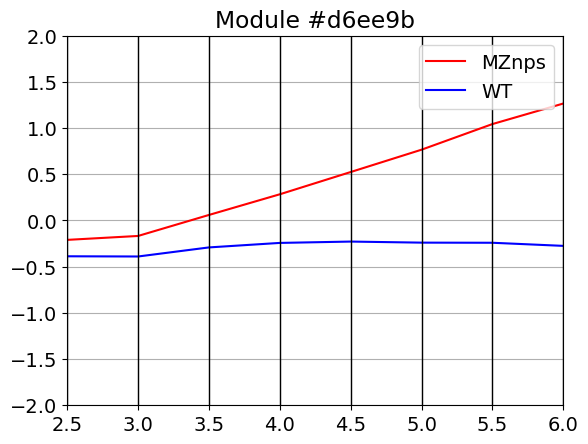

In [31]:
# Make line plots of trends
trends_long = trends.reset_index(drop=False).melt(id_vars='Cluster')
trends_long[['Condition', 'HPF']] = trends_long['Sample_type'].str.split('_', n=1, expand=True)
trends_long['HPF'] = trends_long['HPF'].str.removesuffix('hpf').astype(float)

for i in cluster_order:
    print(i)
    trends_plot = trends_long[trends_long['Cluster'] == i].pivot_table(values='value', index='Condition', columns='HPF').reset_index(drop=False)
    pd.plotting.parallel_coordinates(trends_plot, class_column = 'Condition', color=['red', 'blue'])
    plt.ylim((-2, 2))
    plt.title(f"Module {i}")
    # plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_{i}_trends_lineplot.pdf')
    plt.show()


In [32]:
# Create dataframe with cluster annotation
top_genes = sdata.var[sdata.var.hvg_any]
cluster_annotation = top_genes.merge(bulk_mean.T, how='left', left_index=True, right_index=True)
cluster_annotation['Cluster'] = row_colors

In [33]:
# # Create dataframe with cluster annotation
# cluster_annotation = top_genes.merge(bulk_mean.T, how='left', left_index=True, right_index=True)
# cluster_annotation['Cluster'] = row_colors
# cluster_annotation['Cluster'] = cluster_annotation['Cluster'].astype('category')
# cluster_annotation['Cluster'] = cluster_annotation['Cluster'].cat.reorder_categories(cluster_order)
# cluster_annotation.sort_values(['Cluster', 'combined_rank']).groupby('Cluster').head()


In [34]:
# Get correlation within each cluster with each trend
cluster_corr = []
corr_rank = []
for i in cluster_order:
    cluster_corr.append(bulk_mean.T[row_colors == i].T.corrwith(trends.T[i], method='spearman'))

cluster_corr = pd.concat(cluster_corr)
cluster_corr.name = 'Cluster_rho'
cluster_annotation = cluster_annotation.merge(cluster_corr, how='left', left_index=True, right_index=True)
cluster_annotation.sort_values(['Cluster', 'Cluster_rho'], ascending=[True, False]).groupby('Cluster').head()

gene_ids    feature_types  \
anp32a             ENSDARG00000006487  Gene Expression   
apip               ENSDARG00000003132  Gene Expression   
atp5pd             ENSDARG00000098355  Gene Expression   
pin1               ENSDARG00000101915  Gene Expression   
CABZ01074307.2     ENSDARG00000113364  Gene Expression   
pkp2               ENSDARG00000023026  Gene Expression   
si:dkey-7i4.9      ENSDARG00000095708  Gene Expression   
si:dkey-7l6.3      ENSDARG00000094514  Gene Expression   
slc16a9b           ENSDARG00000104687  Gene Expression   
zgc:110425         ENSDARG00000058479  Gene Expression   
rabac1             ENSDARG00000004171  Gene Expression   
rpf2               ENSDARG00000043960  Gene Expression   
hebp2              ENSDARG00000042630  Gene Expression   
acaa2              ENSDARG00000038881  Gene Expression   
rnf113a            ENSDARG00000037930  Gene Expression   
tbc1d9-1           ENSDARG00000043627  Gene Expression   
bmpr1ba            ENSDARG00000104100  Gene Expression   
wwc3               ENSDARG00000061654  Gene Expression   
lrrc42             ENSDARG00000030591  Gene Expression   
usp45              ENSDARG00000075013  Gene Expression   
gsnb               ENSDARG00000045262  Gene Expression   
gpd1l              ENSDARG00000040024  Gene Expression   
igf2b              ENSDARG00000033307  Gene Expression   
snapc5             ENSDARG00000062476  Gene Expression   
znf1029            ENSDARG00000103031  Gene Expression   
map3k7             ENSDARG00000020469  Gene Expression   
pex11b             ENSDARG00000069147  Gene Expression   
zdhhc13            ENSDARG00000101144  Gene Expression   
pacsin3            ENSDARG00000099339  Gene Expression   
acox3              ENSDARG00000038865  Gene Expression   
rrp8               ENSDARG00000071652  Gene Expression   
nol7               ENSDARG00000075795  Gene Expression   
si:rp71-45k5.2     ENSDARG00000093129  Gene Expression   
cdca5              ENSDARG00000044437  Gene Expression   
FQ976914.1         ENSDARG00000098654  Gene Expression   
tefb               ENSDARG00000098103  Gene Expression   
si:ch211-117k10.3  ENSDARG00000090914  Gene Expression   
rxrga              ENSDARG00000005593  Gene Expression   
iqsec1b            ENSDARG00000016551  Gene Expression   
mrtfab             ENSDARG00000076229  Gene Expression   
il10rb             ENSDARG00000078042  Gene Expression   
mid1ip1b           ENSDARG00000019302  Gene Expression   
mapk3              ENSDARG00000070573  Gene Expression   
cct3               ENSDARG00000016173  Gene Expression   
ptgdsb.1           ENSDARG00000027088  Gene Expression   

                                              genome        gene_symbol  \
anp32a             Danio_rerio_z11_CAAXRedCD4noprrg2             anp32a   
apip               Danio_rerio_z11_CAAXRedCD4noprrg2               apip   
atp5pd             Danio_rerio_z11_CAAXRedCD4noprrg2             atp5pd   
pin1               Danio_rerio_z11_CAAXRedCD4noprrg2               pin1   
CABZ01074307.2     Danio_rerio_z11_CAAXRedCD4noprrg2     CABZ01074307.2   
pkp2               Danio_rerio_z11_CAAXRedCD4noprrg2               pkp2   
si:dkey-7i4.9      Danio_rerio_z11_CAAXRedCD4noprrg2      si:dkey-7i4.9   
si:dkey-7l6.3      Danio_rerio_z11_CAAXRedCD4noprrg2      si:dkey-7l6.3   
slc16a9b           Danio_rerio_z11_CAAXRedCD4noprrg2           slc16a9b   
zgc:110425         Danio_rerio_z11_CAAXRedCD4noprrg2         zgc:110425   
rabac1             Danio_rerio_z11_CAAXRedCD4noprrg2             rabac1   
rpf2               Danio_rerio_z11_CAAXRedCD4noprrg2               rpf2   
hebp2              Danio_rerio_z11_CAAXRedCD4noprrg2              hebp2   
acaa2              Danio_rerio_z11_CAAXRedCD4noprrg2              acaa2   
rnf113a            Danio_rerio_z11_CAAXRedCD4noprrg2            rnf113a   
tbc1d9-1           Danio_rerio_z11_CAAXRedCD4noprrg2           tbc1d9-1   
bmpr1ba            Danio_rerio_z11_CAAXRedCD4noprrg2            bmpr1ba   
wwc3      

In [35]:
# # Create combined rank based on 12hpf stats and cluster rho
# corr_rank = []
# for i in cluster_order:
#     corr_rank.append(bulk_mean.T[row_colors == i].T.corrwith(trends.T[i], method='spearman').rank(axis=0, method='dense', ascending=False))

# corr_rank = pd.concat(corr_rank)
# corr_rank.name = 'Cluster_rank'
# cluster_annotation = cluster_annotation.merge(corr_rank, how='left', left_index=True, right_index=True)
# cluster_annotation['Importance_rank'] = cluster_annotation['Cluster_rank'] + cluster_annotation['combined_rank']
# cluster_annotation.sort_values(['Cluster', 'Importance_rank'], ascending=[True, True]).groupby('Cluster').head()


### Save cluster annotation results

In [36]:
# cluster_annotation.to_csv(f'{outdir}/scMZnps_HVG_cluster_annotation.csv')
# cluster_annotation.to_csv(f'{syncdir}/scMZnps_HVG_cluster_annotation.csv')


### Test enrichment for temporal EMs in KO markers

In [37]:
# Load marker lists
res = 'KO_clusters'
n_genes = 12 # Number of genes per tissue
all_genes = [pd.read_csv(f'{outdir}/{res}/DEGs_{res}_cluster_{clust}.csv', index_col=0).sort_values('combined_rank') for clust in ['KO 1', 'KO 2', 'KO 3', 'KO 4', 'KO 5']]
all_genes = pd.concat(all_genes)
all_genes = all_genes.sort_values(['Cluster', 'combined_rank'])
# top_genes = top_genes.merge(sdata_KO.var, how='left', left_index=True, right_index=True)
all_genes = all_genes.merge(sdata.var, how='left', left_index=True, right_index=True)

# Remove ribosomal and ubiquitously detected genes (>50% detection) 
# top_genes = top_genes[top_genes.either_sig & (top_genes.pct_nz_reference < 0.2) & (top_genes.logOR > 0)]
top_genes = all_genes[all_genes.either_sig & (all_genes.pct_nz_reference < 0.2) & (all_genes.logOR > 0) & (all_genes.pct_cells_detected < 60) & (all_genes.Biotype == 'protein_coding')]
# top_genes.sort_values(['Cluster', 'combined_rank']).to_csv(f'{syncdir}/DEG_KOclusters.csv')
print(top_genes.Cluster.value_counts())

# Add var info for top genes
top_genes.sort_values(['Cluster', 'combined_rank']).groupby('Cluster').head(n_genes)


Cluster
KO 1    4835
KO 5    1408
KO 3     410
KO 4     102
KO 2      88
Name: count, dtype: int64


Cluster   TP   FP   FN   TN         FE            OR  \
ednraa                  KO 1   62    0  488  260   1.472727  3.303279e+08   
znf703                  KO 1  240   12  310  248   1.402597  1.600000e+01   
ahnak                   KO 1  220   10  330  250   1.408696  1.666667e+01   
si:dkey-261h17.1        KO 1  384   49  166  211   1.306068  9.961151e+00   
anxa11a                 KO 1  335   35  215  225   1.333415  1.001661e+01   
pleca                   KO 1  336   35  214  225   1.333791  1.009346e+01   
bcar1                   KO 1  330   35  220  225   1.331507  9.642857e+00   
tspan15                 KO 1  220   15  330  245   1.378723  1.088889e+01   
cdh1                    KO 1  355   44  195  216   1.310321  8.937063e+00   
irf2bpl                 KO 1  215   17  335  243   1.364812  9.173837e+00   
stx1b                   KO 1  105    3  445  257   1.431818  2.021348e+01   
prdm1a                  KO 1   45    0  505  260   1.472727  2.316832e+08   
rrm2                    KO 2   58   77   74  601   2.636364  6.117585e+00   
si:ch211-113a14.22-1    KO 2   28   31  104  647   2.912173  5.619107e+00   
zgc:112234-7            KO 2   27   28  105  650   3.012397  5.969388e+00   
zgc:171759-1            KO 2   21   15  111  663   3.579545  8.362162e+00   
zgc:112234-9            KO 2   27   32  105  646   2.808166  5.191071e+00   
ved                     KO 2   54  120   78  558   1.904389  3.219231e+00   
CU457819.1              KO 2   36   67   96  611   2.144748  3.419776e+00   
zgc:173552              KO 2   27   44  105  634   2.333547  3.705195e+00   
hist1h2a4               KO 2   28   45  104  633   2.353674  3.787179e+00   
hist1h2a6               KO 2   41   89   91  589   1.935315  2.981726e+00   
ets2                    KO 2   44   94   88  584   1.956522  3.106383e+00   
CU302436.1              KO 2   21   29  111  649   2.577273  4.233924e+00   
zic2b                   KO 3   71   39   22  678   5.621701  5.610489e+01   
otx1                    KO 3   60   42   33  675   5.123340  2.922078e+01   
sox2                    KO 3   46   30   47  687   5.271647  2.241277e+01   
zgc:101100              KO 3   46   17   47  700   6.359447  4.030038e+01   
otx2a                   KO 3   39   18   54  699   5.959253  2.804630e+01   
sox19a                  KO 3   66  112   27  605   3.229431  1.320437e+01   
wnt4a                   KO 3   35   10   58  707   6.774194  4.266379e+01   
otx2b                   KO 3   38   20   55  697   5.706340  2.407818e+01   
pax3a                   KO 3   44   25   49  692   5.553997  2.485551e+01   
spsb4a                  KO 3   64  115   29  602   3.114075  1.155262e+01   
auts2b                  KO 3   35   18   58  699   5.751674  2.343391e+01   
pax6a                   KO 3   34   21   59  696   5.384164  1.909927e+01   
dlb                     KO 4   23   70    1  716   8.346774  2.352571e+02   
nhlh2                   KO 4   19   11    5  775  21.375000  2.677273e+02   
ebf2                    KO 4   22   42    2  744  11.601562  1.948571e+02   
onecut1                 KO 4   23  134    1  652   4.944268  1.119104e+02   
elavl3                  KO 4   20   30    4  756  13.500000  1.260000e+02   
si:ch211-215d8.2        KO 4   14    3   10  783  27.794118  3.654000e+02   
her13                   KO 4   14    5   10  781  24.868421  2.186800e+02   
ebf3a-1                 KO 4   18   28    6  758  13.206522  8.121428e+01   
scrt2                   KO 4   16   16    8  770  16.875000  9.625000e+01   
vim                     KO 4   19   47    5  739   9.715909  5.974894e+01   
lzts1                   KO 4   21   90    3  696   6.385135  5.413333e+01   
gadd45gb.1              KO 4   16   22    8  764  14.210526  6.945454e+01   
slc16a3                 KO 5   11   45    0  754  14.464286  1.843111e+09   
ddx4                    KO 5   11   83    0  716   8.617021  9.489157e+08   
fam162a                 KO 5   11  123    0  676   6.044776  6.045529e+08   
tipin            

In [38]:
# Create MZT dictionary
gs_dict = {}
genesets = cluster_order

for gs in genesets:
    # Create dataframe of apoptosis genes
    gs_dict[gs] = cluster_annotation[cluster_annotation['Cluster'] == gs].index.to_list()

gs_dict

{'#fed481': ['mapre3b',
  'phlda1',
  'csrp2',
  'pgm3',
  'CR383662.2',
  'si:dkey-180p18.9',
  'si:dkey-117n7.5',
  'caprin2',
  'ccdc146',
  'clcn3',
  'selenos',
  'mef2ab',
  'men1',
  'rtn3',
  'rab1ba',
  'dnajc3b',
  'ptgr1',
  'rcor2',
  'cyp26b1',
  'herc1',
  'tjp1a',
  'ctdspl2b',
  'igdcc3',
  'nap1l4b',
  'si:ch211-194p6.10',
  'tex9',
  'rfx7a',
  'hsd11b2',
  'celf1',
  'mtch2',
  'aplnr2',
  'arhgap1',
  'zgc:158564',
  'dync1li2',
  'tsg101b',
  'hsd17b12b',
  'iqgap1',
  'sirt3',
  'larp7',
  'sbf2',
  'ap1g1',
  'ZNF821',
  'sepsecs',
  'btr12',
  'gak',
  'castor1',
  'bri3bp',
  'kctd10',
  'ube3b',
  'tchp',
  'ankrd13a',
  'apool',
  'stag2a',
  'mtmr2',
  'rps6ka3a',
  'mpdu1a',
  'trpm6',
  'fam151b',
  'lman2lb',
  'cyb561a3a',
  'man1b1b',
  'ddx31',
  'barhl1a',
  'ntmt1',
  'pole3',
  'foxd1',
  'crx',
  'wdfy3',
  'parp8',
  'mob1ba',
  'rhobtb4',
  'tbx2a',
  'surf4l',
  'malt1',
  'pappaa',
  'si:ch1073-322p19.1',
  'tefb',
  'jpt1b',
  'BX005085.7',
  

In [39]:
# Get top gene list removing genes that are ubiquitous
import gseapy as gp

res_list = []

for clust in ['KO 1', 'KO 2', 'KO 3', 'KO 4', 'KO 5']:
    gene_list = top_genes[top_genes['Cluster'] == clust].sort_values(['Cluster', 'combined_rank']).head(500).index.to_list()
    print(f'Number of genes in Cluster {clust}: {len(gene_list)}')

    # Get significantly enriched terms
    enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                     gene_sets=gs_dict, # kegg is a dict object
                     background=sdata.var.index.to_list(), # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     cutoff=0.05,
                     outdir=None,
                     verbose=True)
    
    results = enr2.results
    results = results.sort_values('Adjusted P-value', ascending=True)
    results['Cluster'] = clust
    results['log10_p'] = -np.log10(results['Adjusted P-value'])
    results['logOR'] = np.log2(results['Odds Ratio'])

    results['sig'] = results['Adjusted P-value'] < 0.05
    # results.to_csv(f'{syncdir}/KO_clusters/Temporal_HVG_cluster_Enrichment_KO_clusters_{clust}.csv')
    # results.to_csv(f'{outdir}/KO_clusters/Temporal_HVG_cluster_Enrichment_KO_clusters_{clust}.csv')
    print(results)
    res_list.append(results)


2024-12-19 23:10:26,864 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:26,864 [INFO] Run: gs_ind_0 
2024-12-19 23:10:26,868 [INFO] Done.
2024-12-19 23:10:26,876 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:26,876 [INFO] Run: gs_ind_0 
2024-12-19 23:10:26,879 [INFO] Done.
2024-12-19 23:10:26,886 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:26,886 [INFO] Run: gs_ind_0 
2024-12-19 23:10:26,890 [INFO] Done.
2024-12-19 23:10:26,896 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:26,896 [INFO] Run: gs_ind_0 
2024-12-19 23:10:26,900 [INFO] Done.
2024-12-19 23:10:26,906 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:26,906 [INFO] Run: gs_ind_0 
2024-12-19 23:10:26,909 [INFO] Done.


Number of genes in Cluster KO 1: 500
   Gene_set     Term  Overlap       P-value  Adjusted P-value  Odds Ratio  \
7  gs_ind_0  #fed481   59/625  2.013166e-18      1.811850e-17    4.127602   
4  gs_ind_0  #d6ee9b  65/1131  4.607630e-10      2.073433e-09    2.479204   
6  gs_ind_0  #f98e52   29/498  2.978889e-05      8.936666e-05    2.420380   
3  gs_ind_0  #9e0142  68/1661  5.063859e-05      1.139368e-04    1.727421   
1  gs_ind_0  #5e4fa2  42/1054  2.448415e-03      4.407148e-03    1.646289   
2  gs_ind_0  #86cfa5   25/637  2.046216e-02      3.069324e-02    1.610557   
5  gs_ind_0  #dd4a4c   27/796  7.515873e-02      8.502570e-02    1.384433   
8  gs_ind_0  #ffffbe   28/831  7.557840e-02      8.502570e-02    1.374752   
0  gs_ind_0  #3d95b8   25/802  1.648733e-01      1.648733e-01    1.268388   

   Combined Score                                              Genes Cluster  \
7      168.186653  ganab;iqgap1;adam17a;smarcc2;rab5c;vat1;ap2a1;...    KO 1   
4       53.298278  aco2;dcn;usp9

/tmp/ipykernel_755823/3295485441.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  res_df['log10_p'][~res_df['sig']] = 0
/tmp/ipykernel_755823/3295485441.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

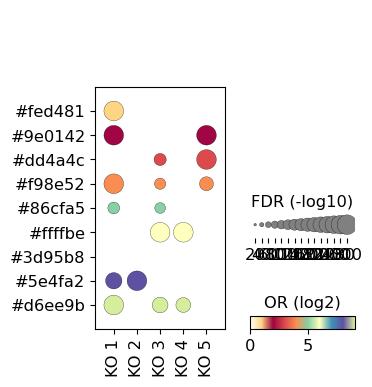

In [40]:
# Create bubble plot of enrihcment results
res_comb = pd.concat(res_list)
res_comb['Cluster'] = res_comb['Cluster'].astype('category')
res_comb['Term'] = res_comb['Term'].astype('category')
res_comb['Term'] = res_comb['Term'].cat.reorder_categories(cluster_order)

res_df = res_comb.copy()
# res_df = res_df[res_df['sig']]
res_df['log10_p'][~res_df['sig']] = 0
res_df['Term'] = res_df['Term'].astype('category')

marker = res_df.pivot_table(values='logOR', columns='Term', index='Cluster').fillna(0)
pval = res_df.pivot_table(values='log10_p', columns='Term', index='Cluster').fillna(0)
pval[pval > 3] = 3 # clip values to 8 logOR

dummy = sc.AnnData(marker)
dummy.var['Cluster'] = dummy.var_names.to_list()
dummy.obs['Term'] = dummy.obs_names.to_list()
dummy.obs['Term'] = dummy.obs['Term'].astype('category')

# Plot temporal cluster enrichment per EM
cols = cluster_order[:len(cluster_order)]

cmap0 = mpl.colors.LinearSegmentedColormap.from_list('', ["White", *cols])

counter = 1
for clust in cluster_order:
    marker[clust] = counter
    counter += 1
  
sc.pl.dotplot(dummy, dummy.var['Cluster'].to_list(), 'Term', dendrogram=False, dot_color_df=marker, dot_size_df=pval, colorbar_title=f'OR (log2)', size_title=f'FDR (-log10)', cmap=cmap0, vmin=0, vmax=len(cluster_order), swap_axes=True,
              # save=f'scMZnps_KO_cluster_DEGs_HVG_cluster_enrichment_log10p_temporal_colors.pdf'
)



### Create heatmaps per cluster for each KO subpopulations

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


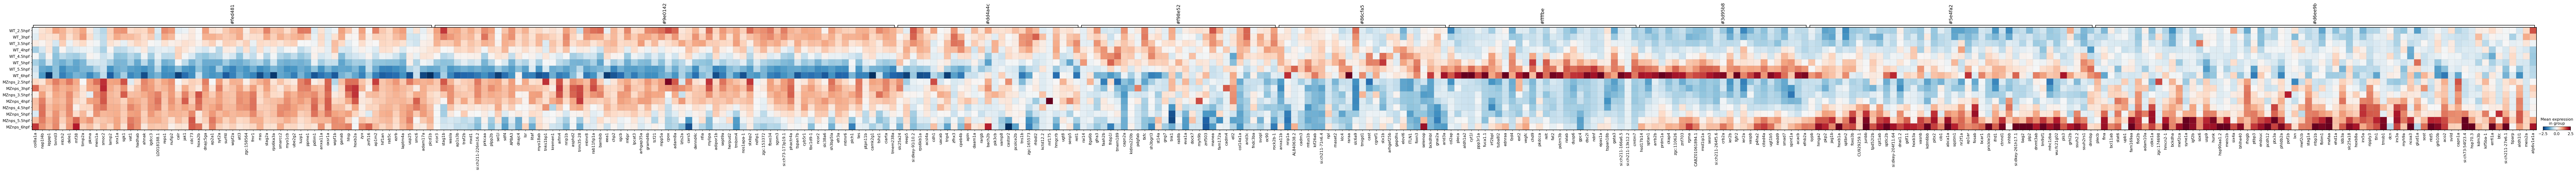

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


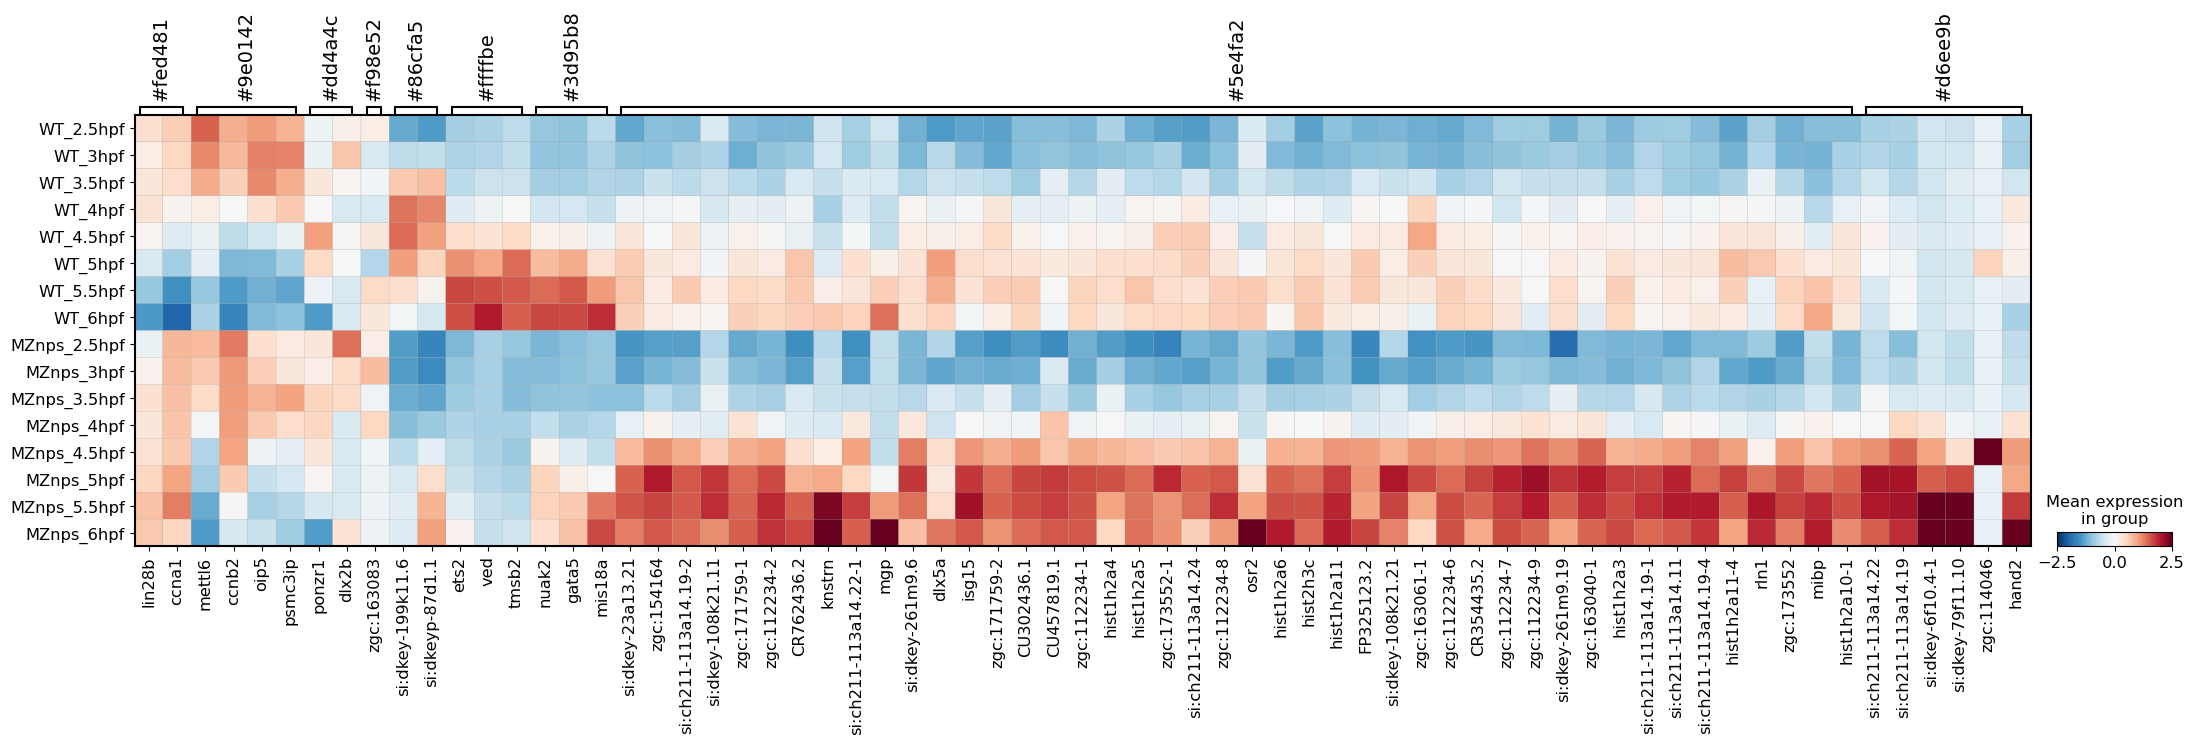

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


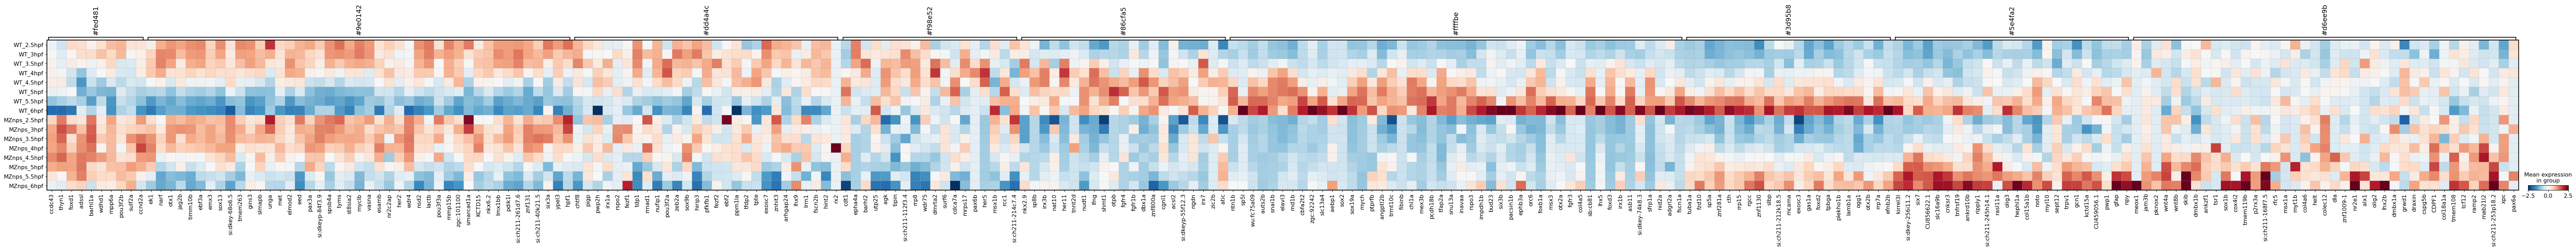

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


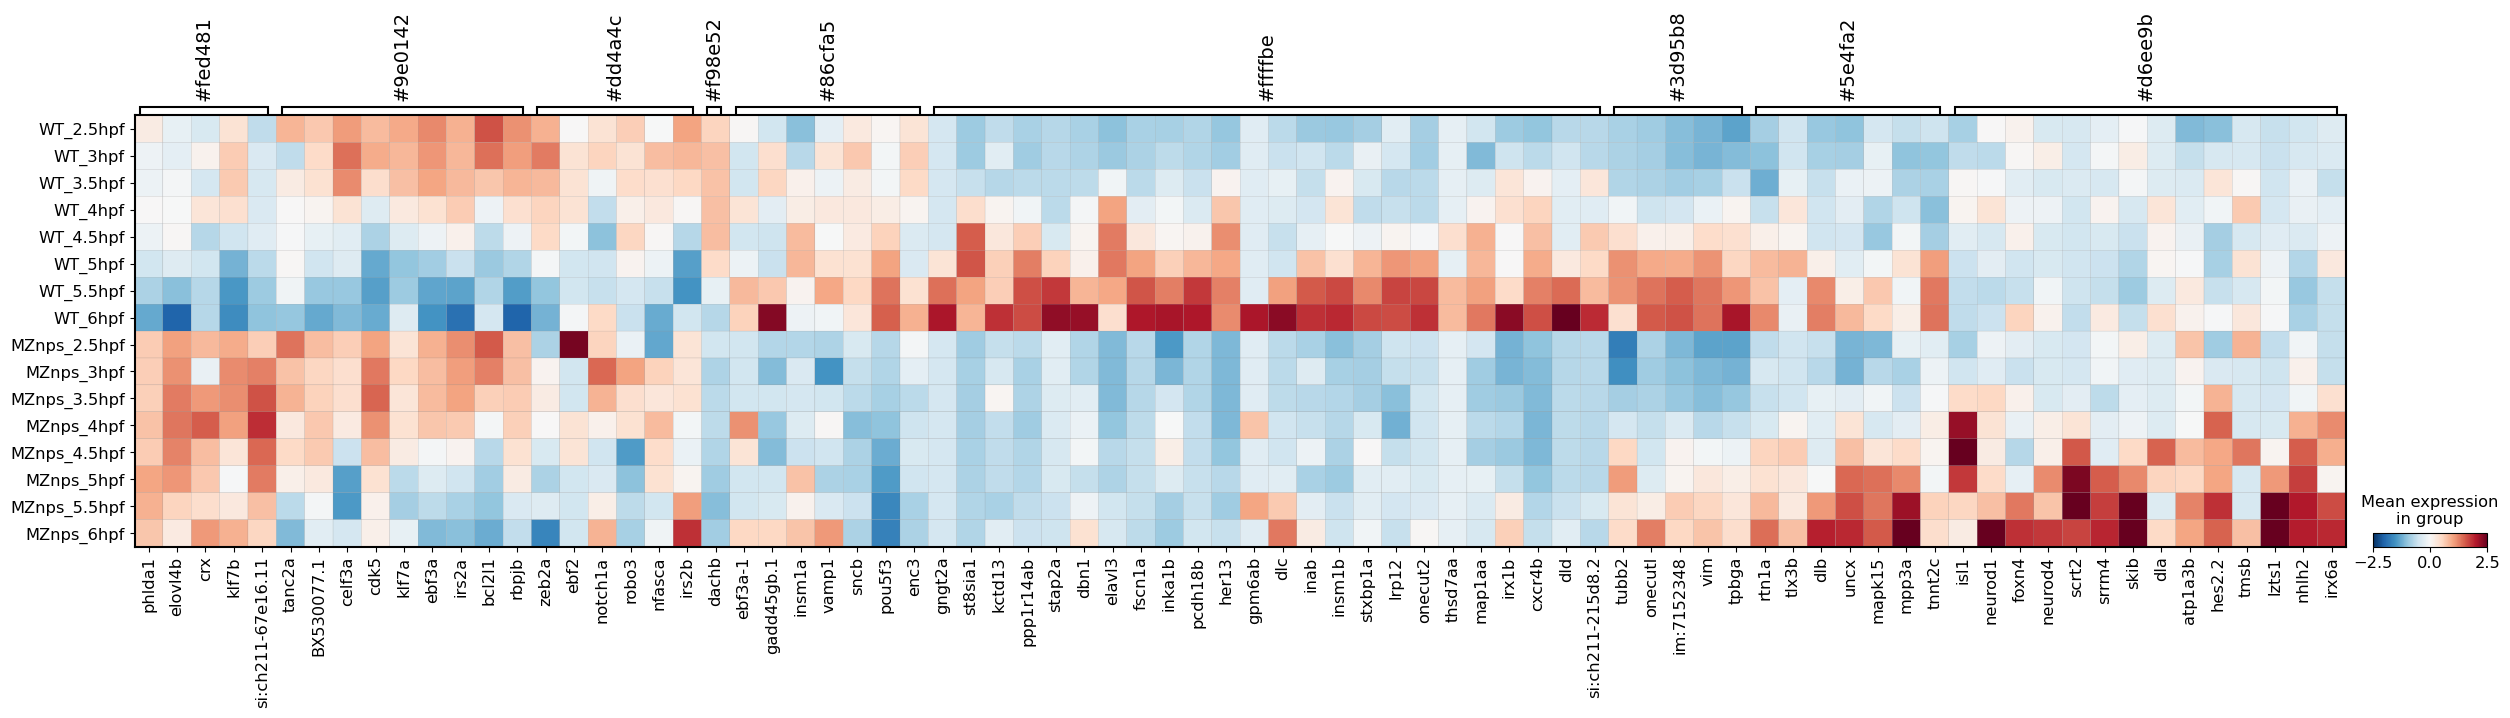

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


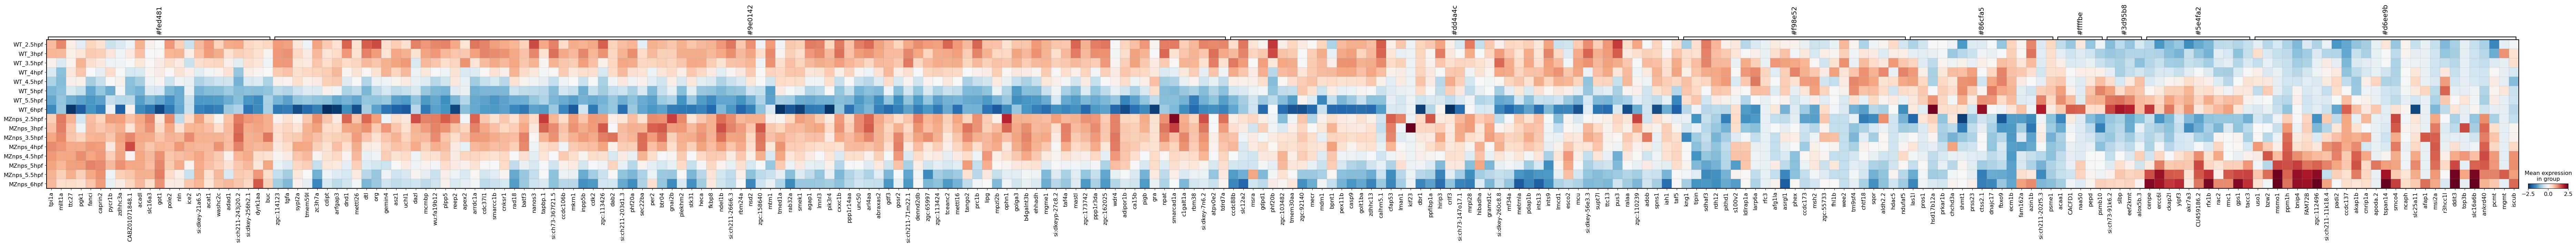

In [41]:
# Create heatmaps per cluster populations
cluster_annotation = cluster_annotation.sort_values(['Cluster', 'Cluster_rho'], ascending=[True, False])

for clust in ['KO 1', 'KO 2', 'KO 3', 'KO 4', 'KO 5']:

    # Import enrichment data
    tmp = pd.read_csv(f'{syncdir}/KO_clusters/Temporal_HVG_cluster_Enrichment_KO_clusters_{clust}.csv', index_col=0)
    # tmp = res_comb[res_comb.Cluster == clust]
    if tmp.shape[0] == 0: continue

    # Extract genes and order based on rho
    genes_dict = {}
    for i in cluster_order:
        if i not in tmp.Term.to_list(): continue
        genes = str(tmp[tmp.Term == i].reset_index().at[0, 'Genes']).split(";")
        genes_dict[i] = genes
        # genes_dict[i] = cluster_annotation.iloc[cluster_annotation.index.isin(genes),:].index.to_list()
    
    # Visualise marker expression temporally
    sdata_bulk.obs['Sample_type'] = sdata_bulk.obs['Sample_type'].cat.reorder_categories(['WT_2.5hpf', 'WT_3hpf', 'WT_3.5hpf', 'WT_4hpf', 'WT_4.5hpf', 'WT_5hpf', 'WT_5.5hpf', 'WT_6hpf','MZnps_2.5hpf', 'MZnps_3hpf', 'MZnps_3.5hpf', 'MZnps_4hpf', 'MZnps_4.5hpf', 'MZnps_5hpf', 'MZnps_5.5hpf',  'MZnps_6hpf'])
        
    sc.pl.matrixplot(
        sdata_bulk, 
        genes_dict,  # List of genes to plot
        groupby='Sample_type',  # Grouping by 'Sample_type'
        standard_scale=None,  # No scaling applied
        cmap='RdBu_r',  # Diverging colormap
        layer='X_scaled',  # Use scaled data
        vmin=-2.5,  # Minimum color value
        vmax=2.5,  # Maximum color value
        swap_axes=False,  # Do not swap axes
        # save=f'matrixplot_scMZnps_KO_cluster_{clust}_marker_bulk_timecourse_temporal_colors.pdf'  # Save file
    )


### Test enrichment for temporal EMs in Tissue markers

In [42]:
# Load marker database
WT_marker_annotation = [pd.read_csv(f'{outdir}/Tissue_KO_clusters/DEGs_Tissue_KO_clusters_cluster_{clust}.csv', index_col=0).sort_values('combined_rank') for clust in sdata[sdata.obs.Condition != 'KO'].obs['Tissue_KO_clusters'].cat.categories]
WT_marker_annotation = pd.concat(WT_marker_annotation)
WT_marker_annotation = WT_marker_annotation.merge(sdata.var, how='left', left_index=True, right_index=True)

WT_marker_annotation = WT_marker_annotation[(WT_marker_annotation.either_sig) & (WT_marker_annotation.pct_nz_reference < 0.5) & (WT_marker_annotation.Biotype == 'protein_coding') & (WT_marker_annotation.logOR > 0)]

# View top TFs for a specific cluster
n_genes = 50 # Number of genes per tissue
marker_annotation = WT_marker_annotation.sort_values(['Cluster', 'combined_rank']).groupby('Cluster').head(n_genes)
tissue_markers = {k: g["names"].tolist() for k,g in marker_annotation.groupby("Cluster")}
tissue_markers

{'Axial': ['tbx16',
  'msgn1',
  'myf5',
  'cdx4',
  'fn1b',
  'snai1a',
  'her7',
  'tuba8l2',
  'tbx16l',
  'hoxc3a',
  'pcdh8',
  'hoxb7a',
  'tcf15',
  'cdx1a',
  'grin2da',
  'rbm38',
  'tbx6',
  'hoxb10a',
  'tob1a',
  'her1',
  'foxc1a',
  'hsp90aa1.1',
  'dlc',
  'actc1a',
  'itm2cb',
  'meox1',
  'angptl7',
  'hoxc8a',
  'lbx2',
  'zgc:56585',
  'ism1',
  'rem1',
  'six4a',
  'hoxc6b',
  'unc45b',
  'im:7138239',
  'mespaa',
  'timm50',
  'aldh1a2',
  'alpi.1',
  'hoxa9a',
  'si:dkey-261h17.1',
  'lpar1',
  'draxin',
  'samd10b',
  'hoxd9a',
  'dmrt2a',
  'mespab',
  'hoxa11b',
  'foxc1b'],
 'Cardiac': ['gata5',
  'rbpms2a',
  'gata6',
  'cdh11',
  'osr1',
  'tbx20',
  'tmem88a',
  'fgfrl1b',
  'hand2',
  'tmem88b',
  'bmp6',
  'cracr2b',
  'pcdh10a',
  'prrx1a',
  'parapinopsinb',
  'ppp1r13ba',
  'hnf1bb',
  'fgf10b',
  'cxcl12a',
  'wt1a',
  'cxcl12b',
  'twist1a',
  'ssuh2.2',
  'foxh1',
  'fli1a',
  'si:dkey-261j4.5',
  'dhrs9',
  'tpm4a',
  'tmsb2',
  'si:ch73-190f9.4',


In [43]:
# Get top gene list removing genes that are ubiquitous
import gseapy as gp

res_list = []

for clust in sdata[sdata.obs.Condition != 'KO'].obs['Tissue_KO_clusters'].cat.categories:
    gene_list = tissue_markers[clust]
    print(f'Number of genes in Cluster {clust}: {len(gene_list)}')

    # Get significantly enriched terms
    enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                     gene_sets=gs_dict, # kegg is a dict object
                     background=sdata.var.index.to_list(), # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     cutoff=0.05,
                     outdir=None,
                     verbose=True)
    
    results = enr2.results
    results = results.sort_values('Adjusted P-value', ascending=True)
    results['Cluster'] = clust
    results['log10_p'] = -np.log10(results['Adjusted P-value'])
    results['logOR'] = np.log2(results['Odds Ratio'])

    results['sig'] = results['Adjusted P-value'] < 0.05
    # results.to_csv(f'{syncdir}/Tissue_KO_clusters/Temporal_HVG_cluster_Enrichment_Tissue_KO_clusters_{clust}.csv')
    # results.to_csv(f'{outdir}/Tissue_KO_clusters/Temporal_HVG_cluster_Enrichment_Tissue_KO_clusters_{clust}.csv')
    print(results)
    res_list.append(results)


2024-12-19 23:10:36,937 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36,938 [INFO] Run: gs_ind_0 
2024-12-19 23:10:36,942 [INFO] Done.
2024-12-19 23:10:36,946 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36,946 [INFO] Run: gs_ind_0 
2024-12-19 23:10:36,950 [INFO] Done.
2024-12-19 23:10:36,953 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36,954 [INFO] Run: gs_ind_0 
2024-12-19 23:10:36,959 [INFO] Done.
2024-12-19 23:10:36,963 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36,963 [INFO] Run: gs_ind_0 
2024-12-19 23:10:36,966 [INFO] Done.
2024-12-19 23:10:36,970 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36,971 [INFO] Run: gs_ind_0 
2024-12-19 23:10:36,974 [INFO] Done.
2024-12-19 23:10:36,978 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36,978 [INFO] Run: gs_ind_0 
2024-12-19 23:10:36,982 [INFO] Done.
2024-12-19 23:10:36,986 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:36

Number of genes in Cluster Enveloping layer: 50
   Gene_set     Term Overlap       P-value  Adjusted P-value  Odds Ratio  \
7  gs_ind_0  #ffffbe  29/831  2.157148e-27      1.725718e-26   31.272665   
0  gs_ind_0  #3d95b8   6/802  1.517860e-02      6.071439e-02    3.454745   
2  gs_ind_0  #86cfa5   3/637  2.174062e-01      5.797498e-01    2.212896   
1  gs_ind_0  #5e4fa2  3/1054  5.022167e-01      9.137819e-01    1.308672   
4  gs_ind_0  #d6ee9b  2/1131  7.879963e-01      9.137819e-01    0.849684   
5  gs_ind_0  #f98e52   1/498  7.209702e-01      9.137819e-01    1.172274   
6  gs_ind_0  #fed481   1/625  7.995592e-01      9.137819e-01    0.928106   
3  gs_ind_0  #9e0142  1/1661  9.876084e-01      9.876084e-01    0.330506   

   Combined Score                                              Genes  \
7     1920.173234  rab25a;krt8;ponzr5;anxa1c;eppk1;si:ch211-98n17...   
0       14.468018  rnf183;stx11b.1;zgc:110333;tmem45b;cldne;dnase...   
2        3.376852                       icn2;s100v1

2024-12-19 23:10:37,143 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:37,143 [INFO] Run: gs_ind_0 
2024-12-19 23:10:37,146 [INFO] Done.
2024-12-19 23:10:37,151 [INFO] Input dict object named with gs_ind_0
2024-12-19 23:10:37,151 [INFO] Run: gs_ind_0 
2024-12-19 23:10:37,155 [INFO] Done.


   Gene_set     Term  Overlap   P-value  Adjusted P-value  Odds Ratio  \
4  gs_ind_0  #d6ee9b  12/1131  0.000018          0.000148    5.351906   
1  gs_ind_0  #5e4fa2  10/1054  0.000258          0.001034    4.604587   
0  gs_ind_0  #3d95b8    7/802  0.003833          0.010222    4.077882   
2  gs_ind_0  #86cfa5    4/637  0.076771          0.153542    2.906338   
6  gs_ind_0  #fed481    3/625  0.209489          0.335183    2.256763   
5  gs_ind_0  #f98e52    2/498  0.359762          0.411156    1.994075   
7  gs_ind_0  #ffffbe    3/831  0.351044          0.411156    1.679406   
3  gs_ind_0  #9e0142   2/1661  0.930663          0.930663    0.562202   

   Combined Score                                              Genes  \
4       58.335718  alx1;foxc1b;cox4i2;pax4;colec12;six1a;robo4;pk...   
1       38.038402  ripply1;col15a1b;alx4a;scxa;tgfbi;col11a1a;zcc...   
0       22.689698       osr1;aplnra;cxcl12b;foxf2a;foxd2;tpm4a;pnocb   
2        7.460351                       ebf3a-1;ca10b;

/tmp/ipykernel_755823/785564636.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  res_df['log10_p'][~res_df['sig']] = 0
/tmp/ipykernel_755823/785564636.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

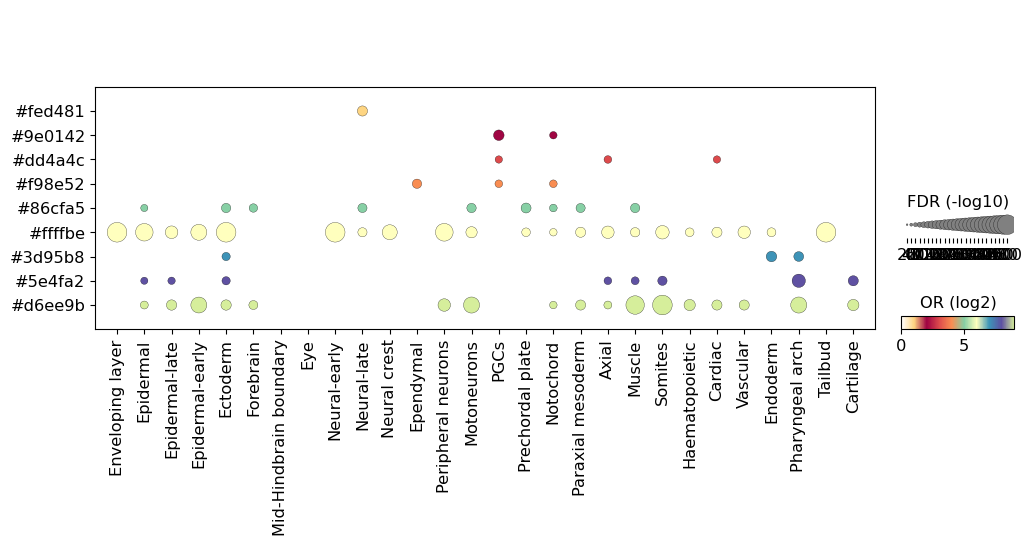

In [44]:
# Make heatmaps of results
res_comb = pd.concat(res_list)
res_comb['Cluster'] = res_comb['Cluster'].astype('category')
res_comb['Cluster'] = res_comb['Cluster'].cat.reorder_categories(sdata[sdata.obs.Condition != 'KO'].obs['Tissue_KO_clusters'].cat.categories)

res_comb['Term'] = res_comb['Term'].astype('category')
res_comb['Term'] = res_comb['Term'].cat.reorder_categories(cluster_order)

res_df = res_comb.copy()
# res_df = res_df[res_df['sig']]
res_df['log10_p'][~res_df['sig']] = 0
res_df['Term'] = res_df['Term'].astype('category')

marker = res_df.pivot_table(values='logOR', columns='Term', index='Cluster').fillna(0)
pval = res_df.pivot_table(values='log10_p', columns='Term', index='Cluster').fillna(0)
pval[pval > 5] = 5 # clip values to 8 logOR

dummy = sc.AnnData(marker)
dummy.var['Cluster'] = dummy.var_names.to_list()
dummy.obs['Term'] = dummy.obs_names.to_list()
dummy.obs['Term'] = dummy.obs['Term'].astype('category')

# Plot temporal cluster enrichment per EM
cols = cluster_order[:len(cluster_order)]

cmap0 = mpl.colors.LinearSegmentedColormap.from_list('', ["White", *cols])

counter = 1
for clust in cluster_order:
    marker[clust] = counter
    counter += 1
  
sc.pl.dotplot(dummy, dummy.var['Cluster'].to_list(), 'Term', dendrogram=False, dot_color_df=marker, dot_size_df=pval, colorbar_title=f'OR (log2)', size_title=f'FDR (-log10)', cmap=cmap0, vmin=0, vmax=len(cluster_order), swap_axes=True,
              # save=f'scMZnps_Tissue_markers_HVG_cluster_enrichment_log10p_temporal_colors.pdf'
)


### Create heatmaps per cluster for each WT tissue

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


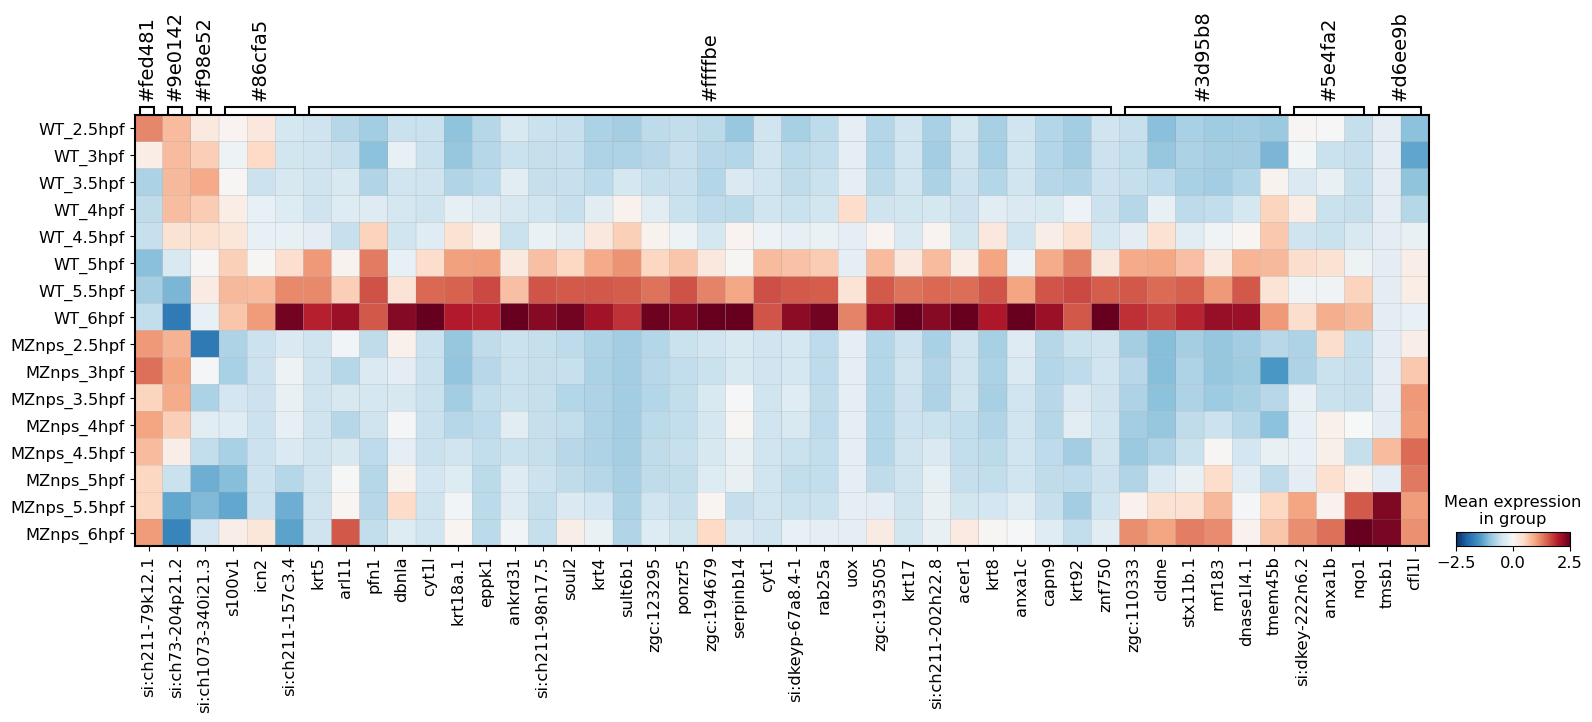

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


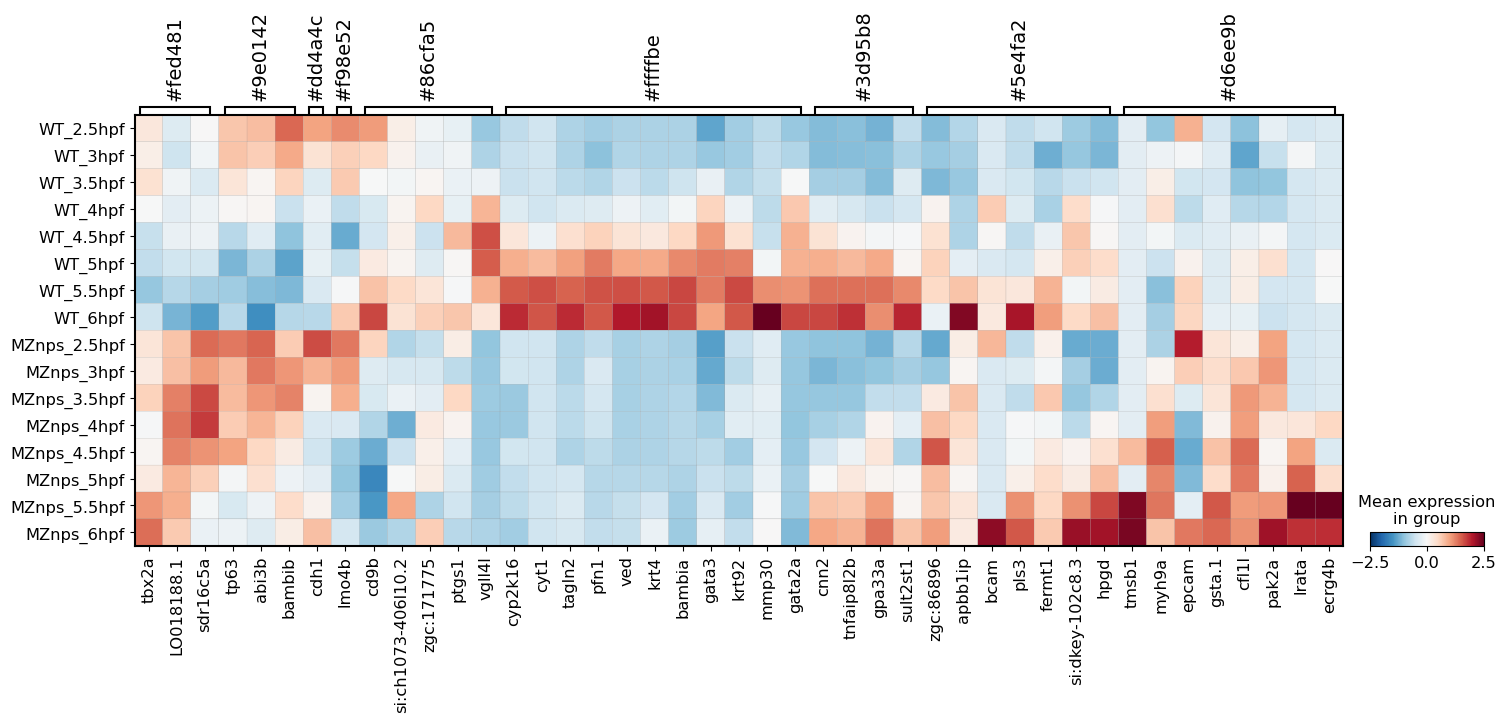

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


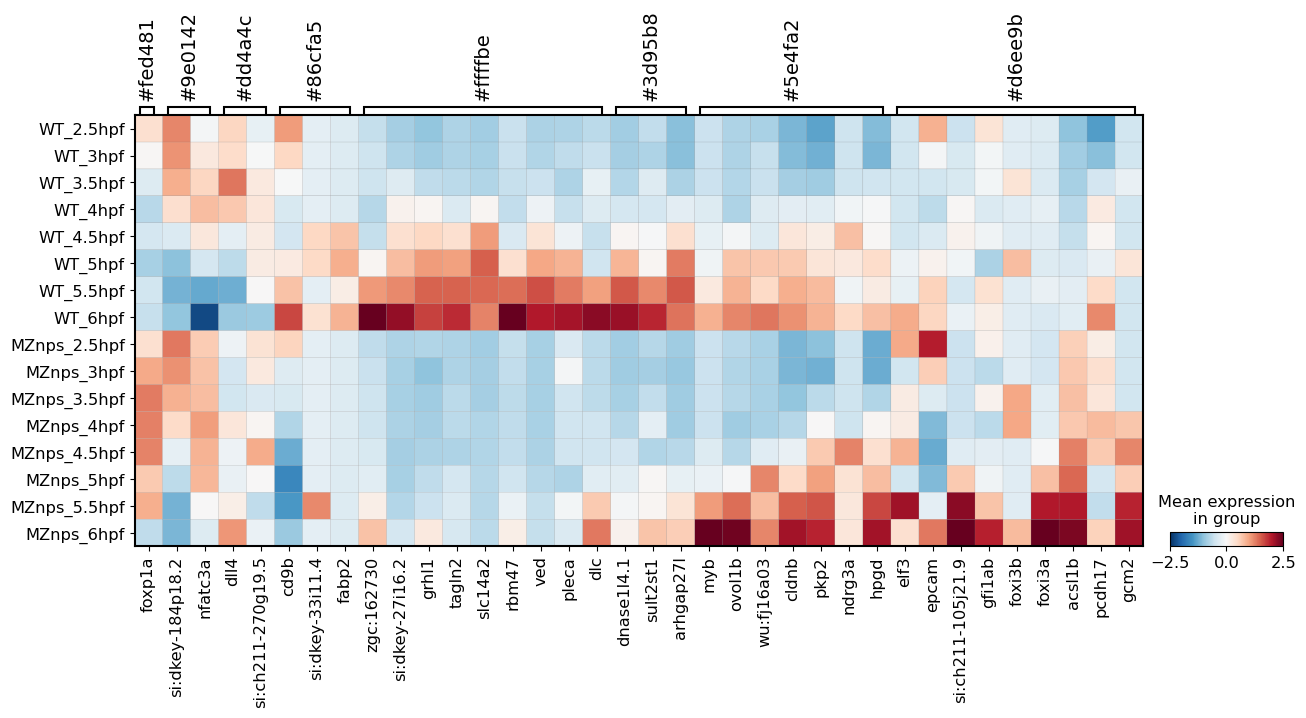

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


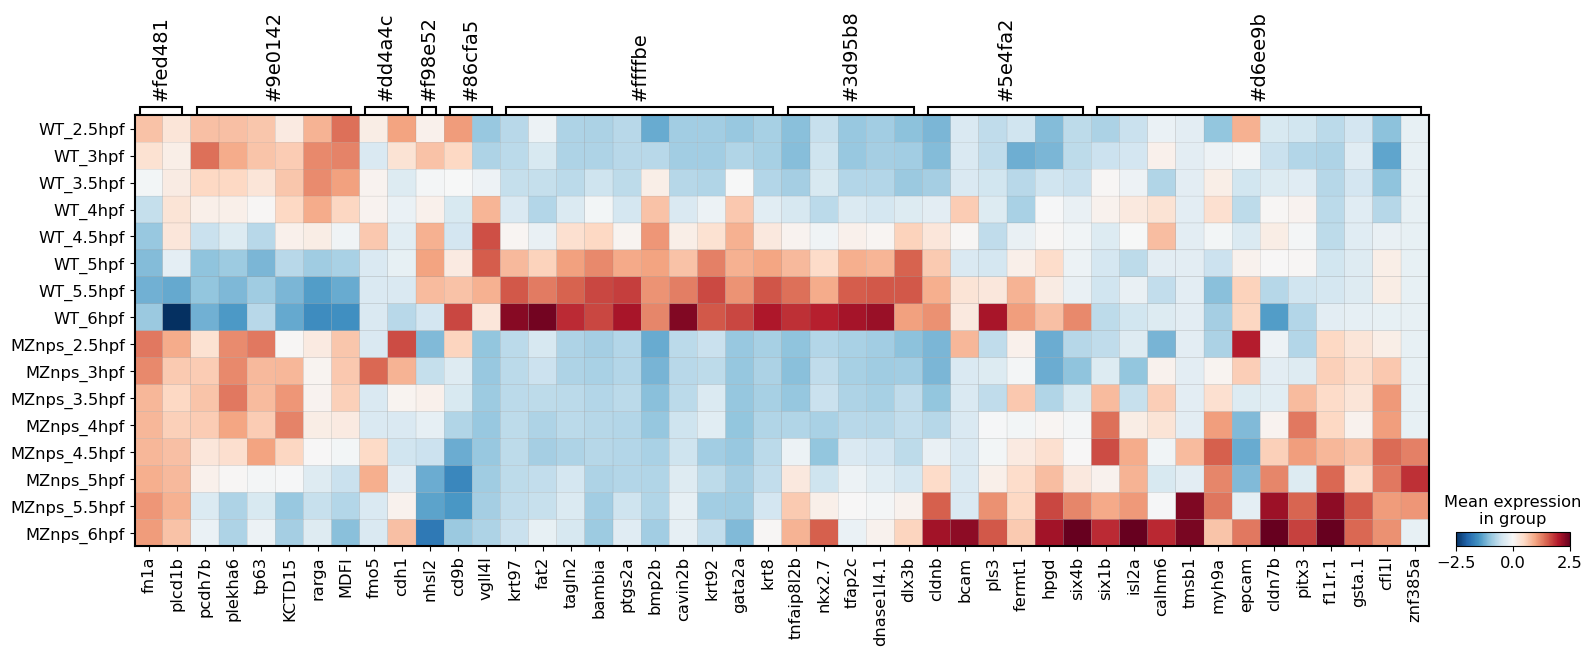

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


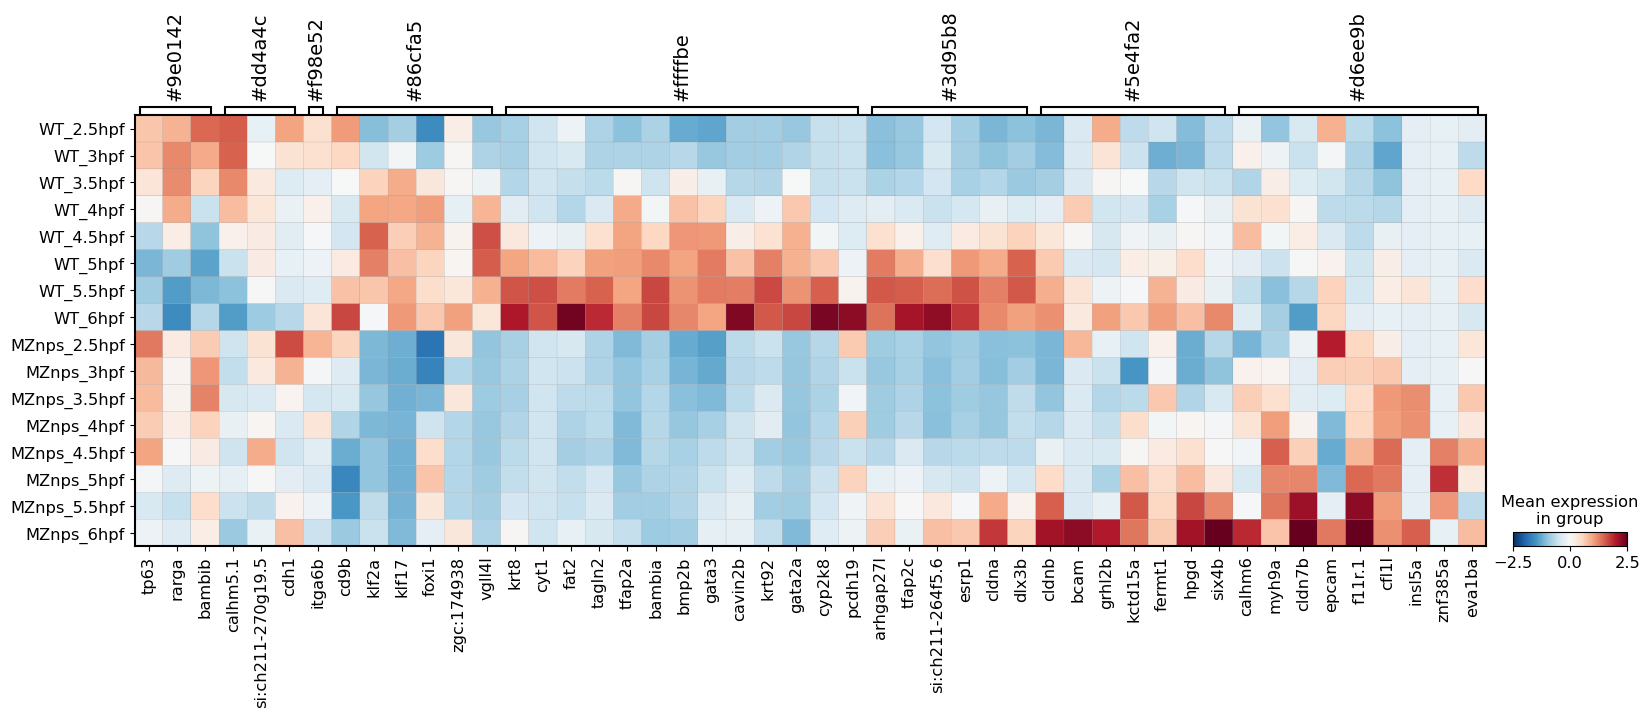

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


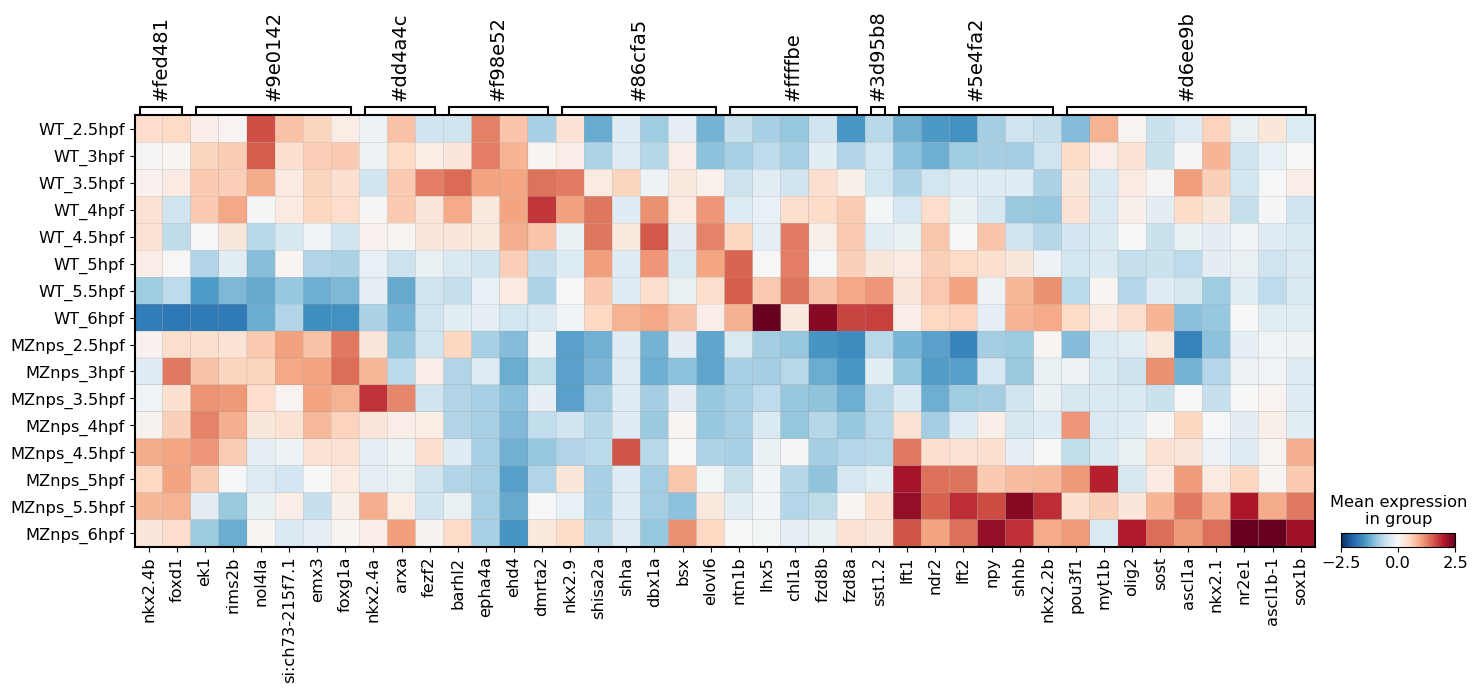

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


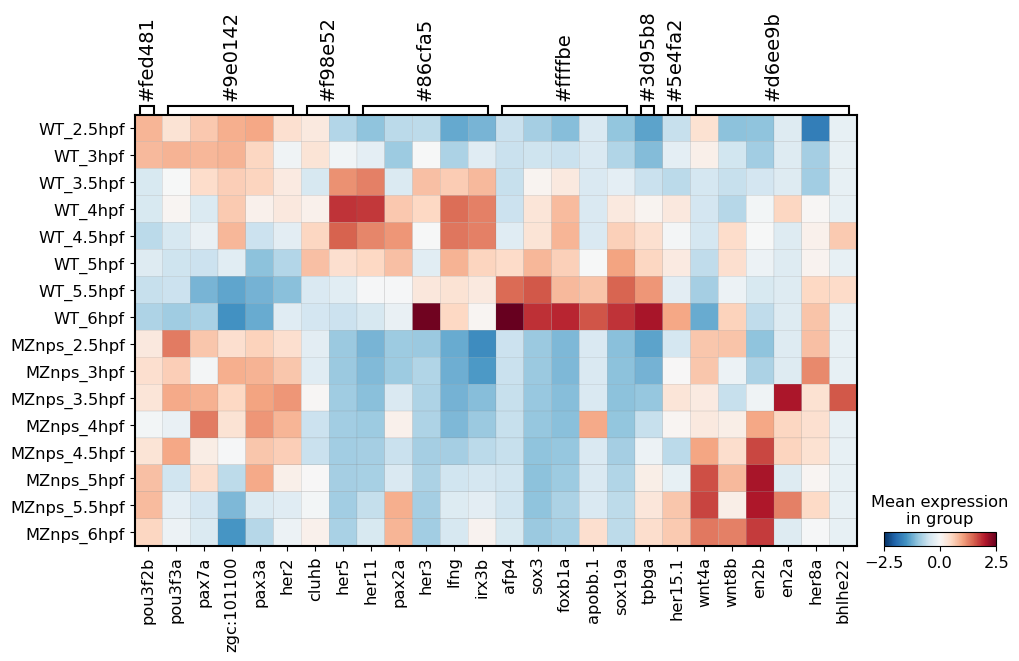

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


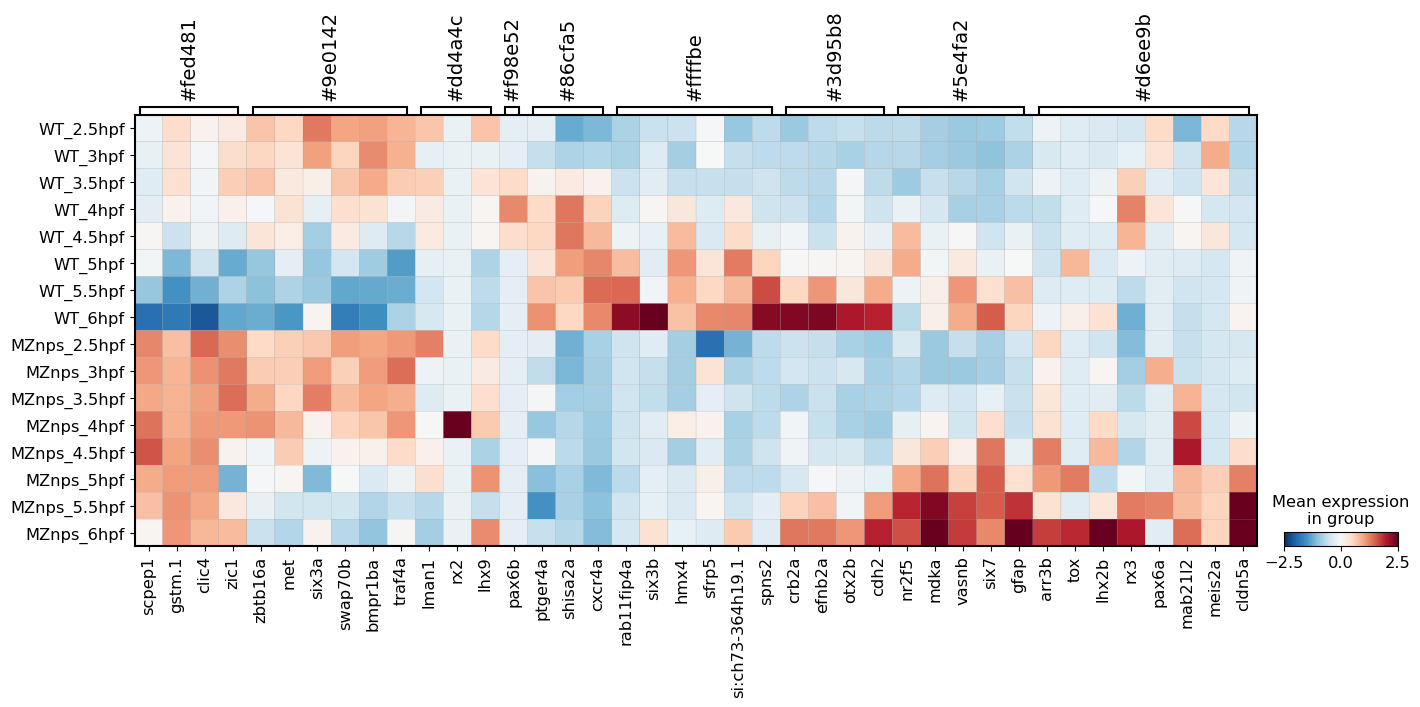

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


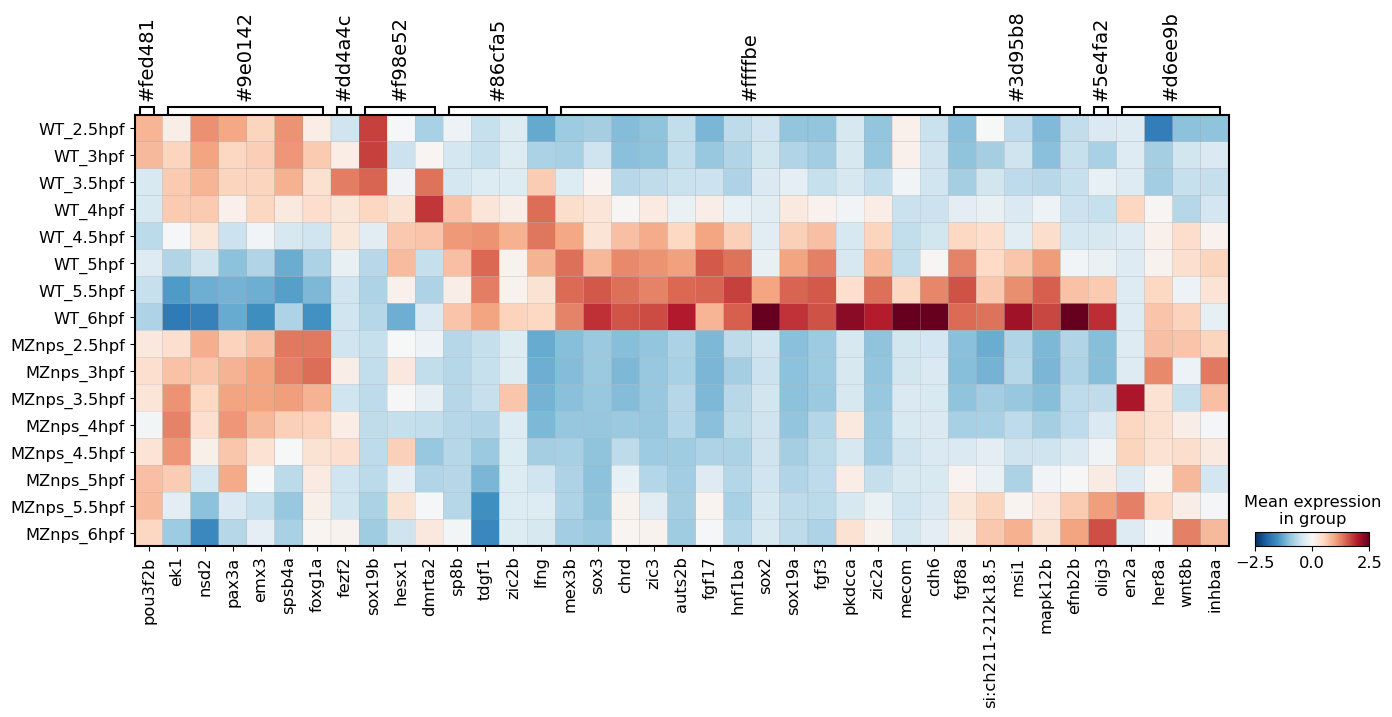

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


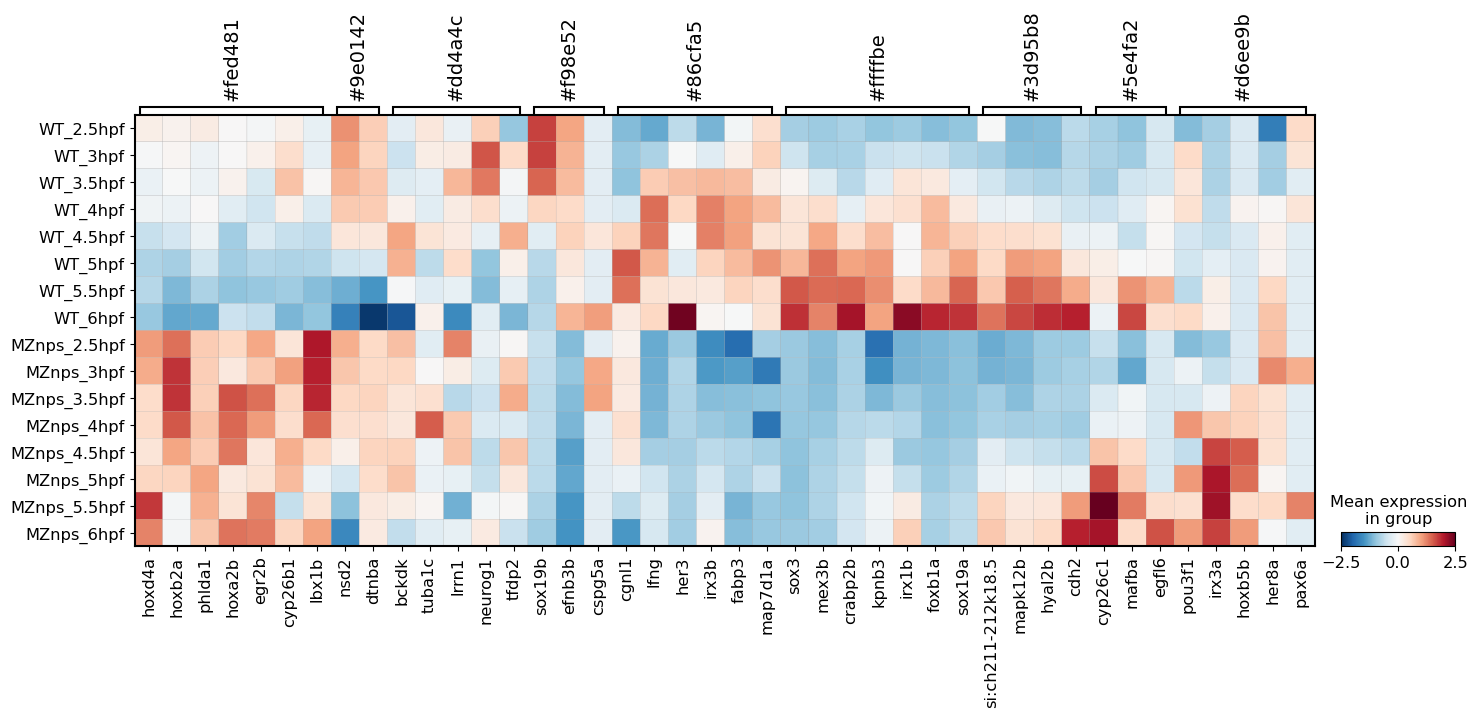

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


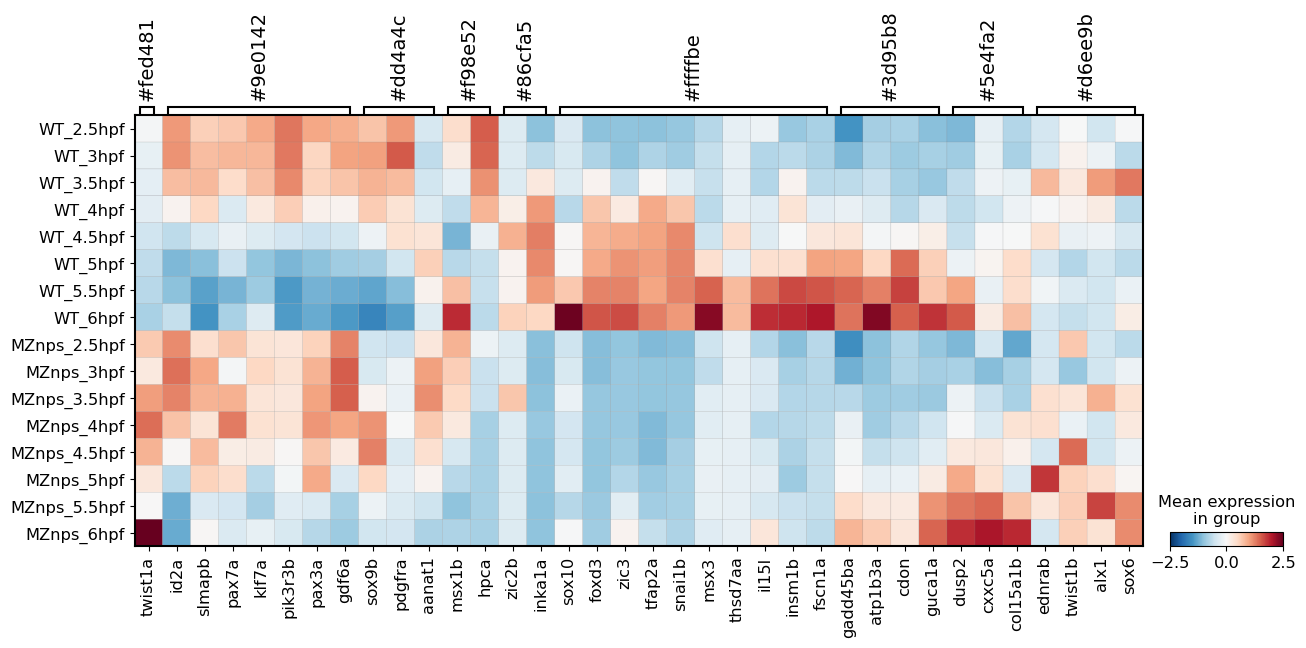

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


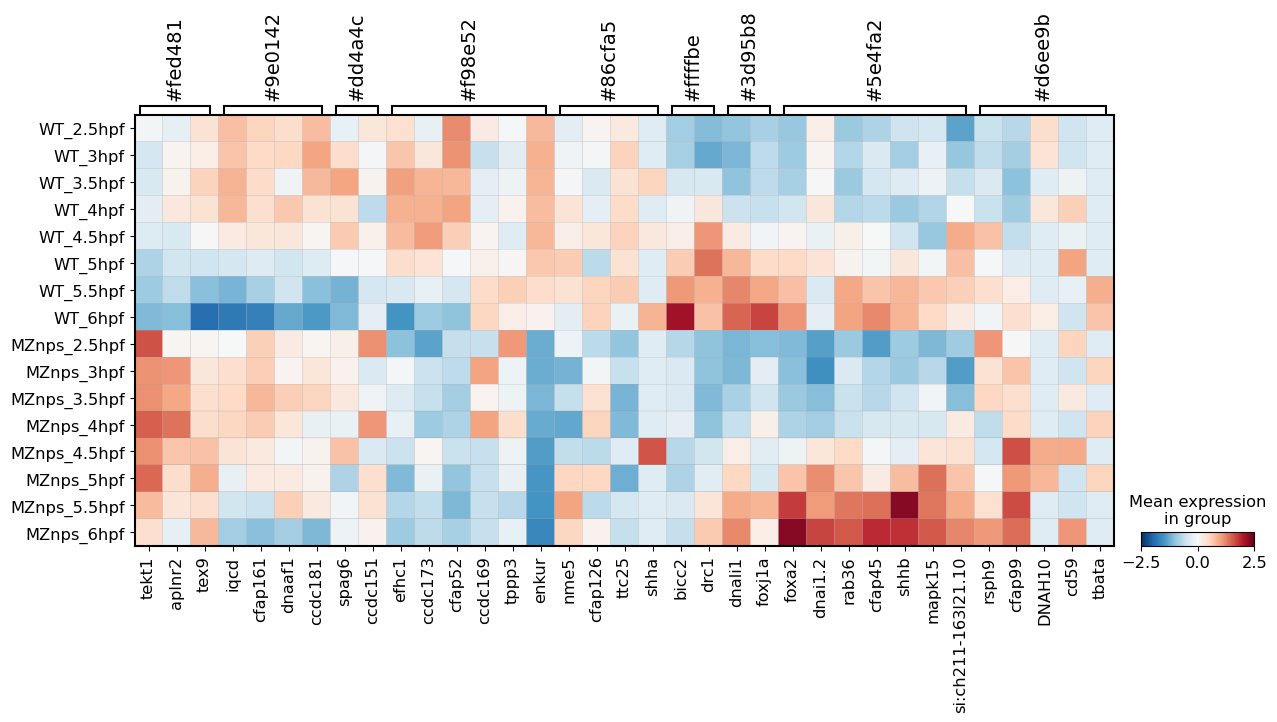

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


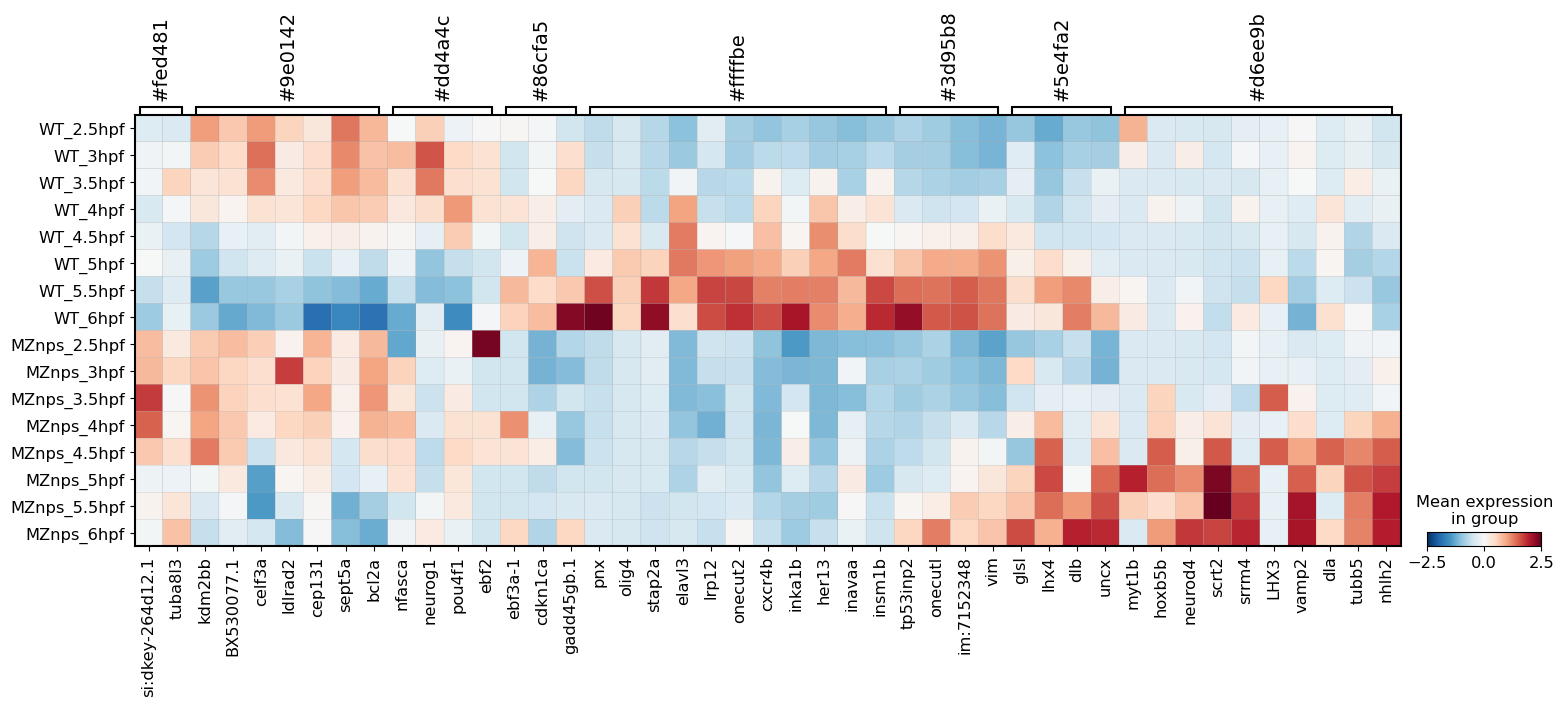

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


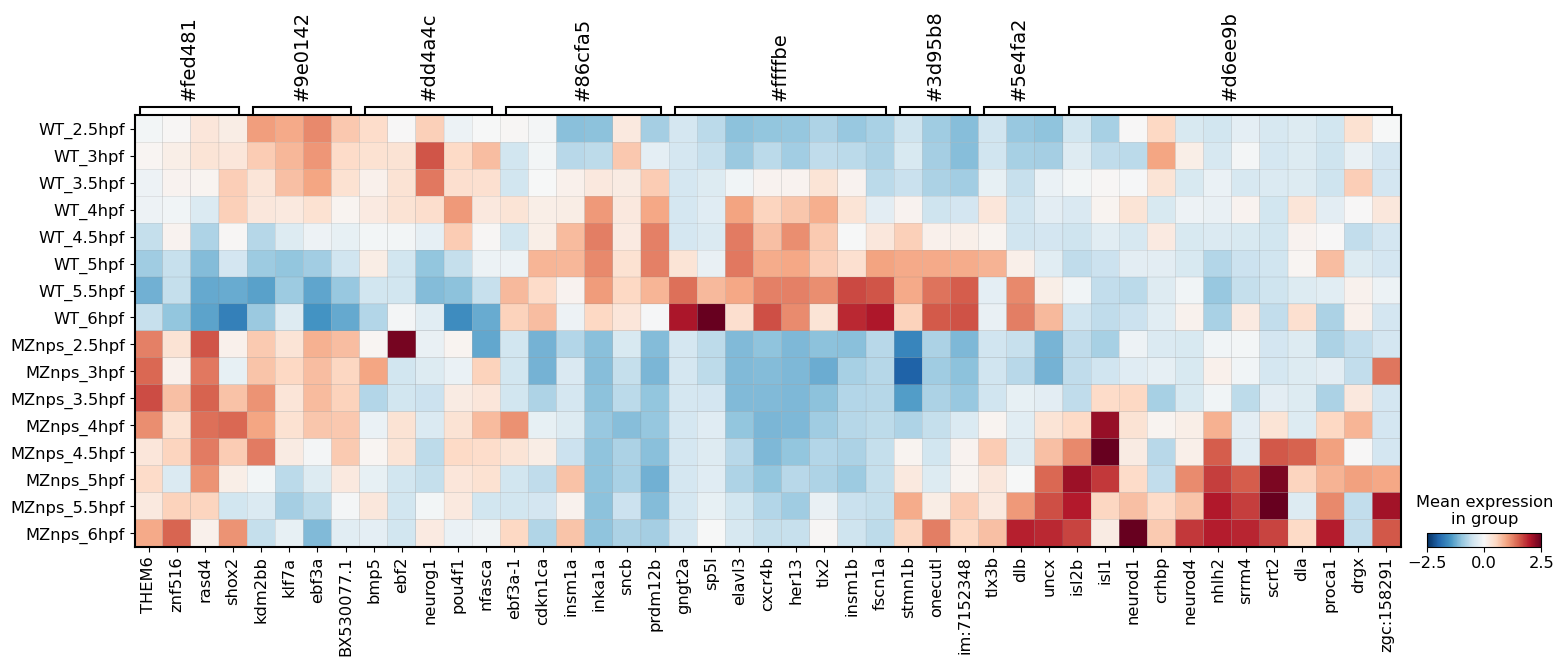

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


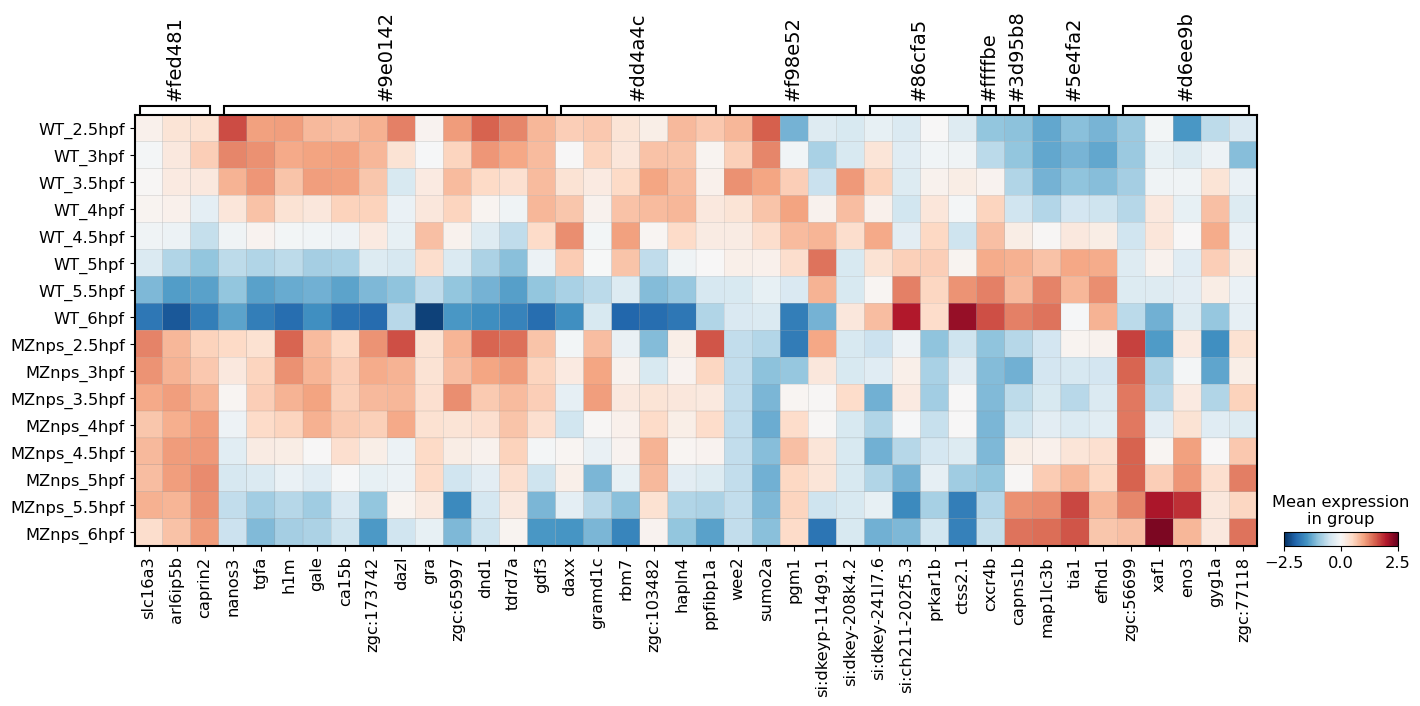

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


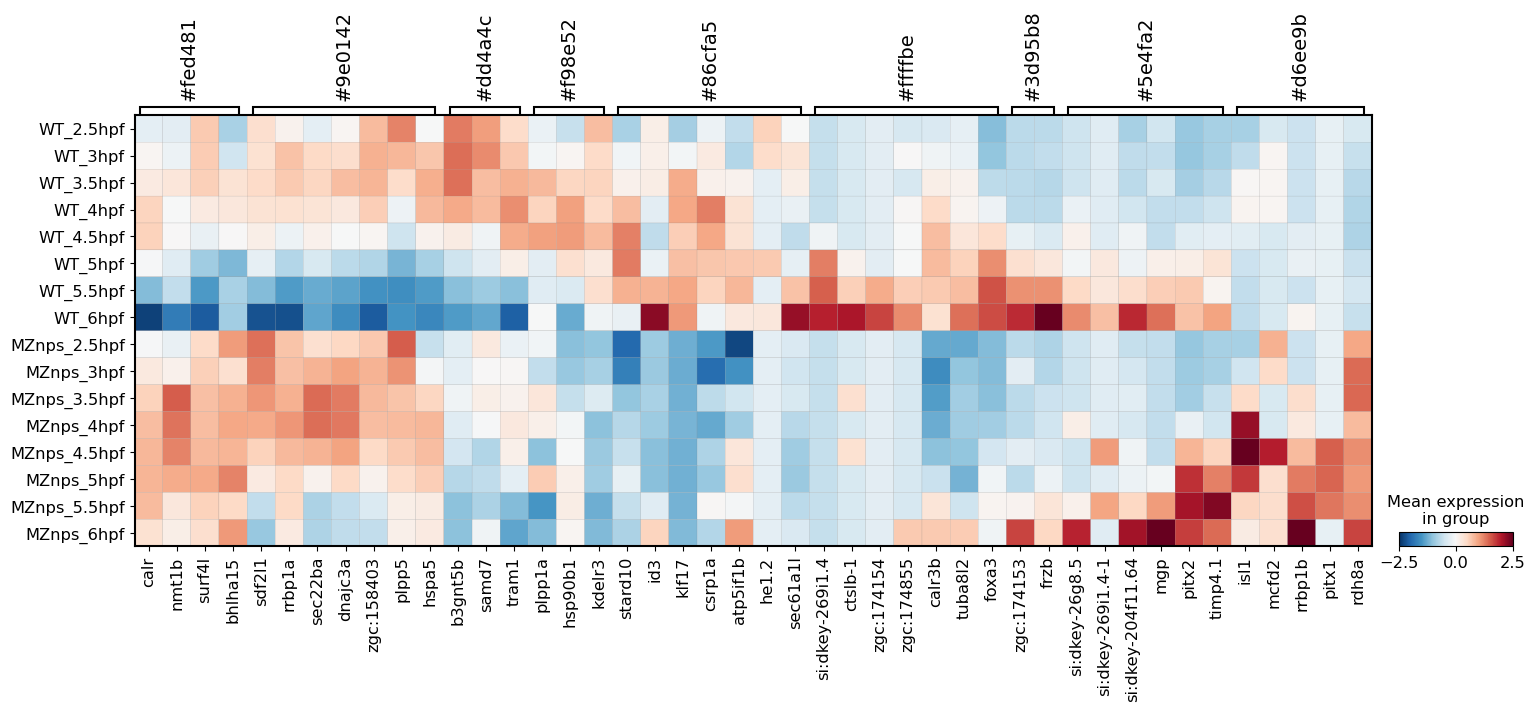

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


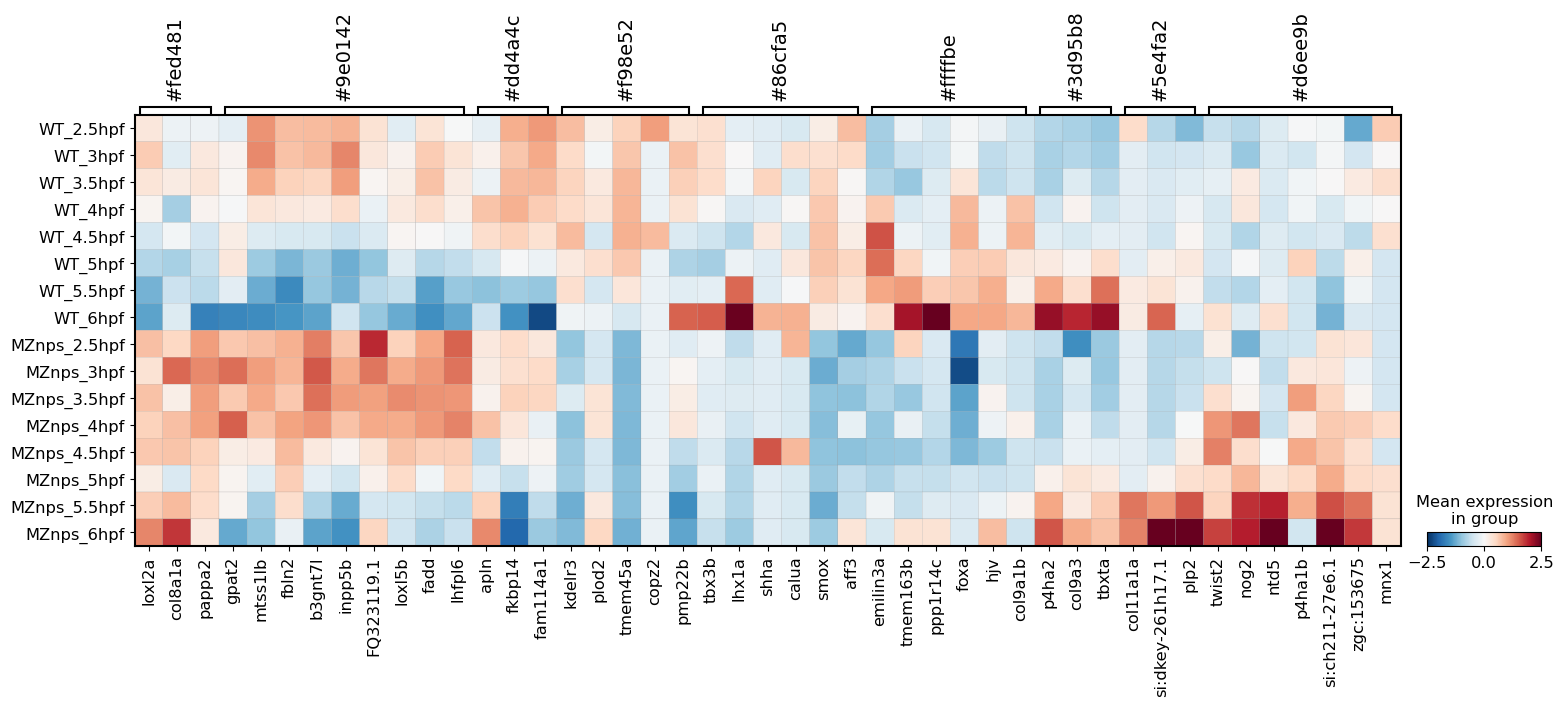

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


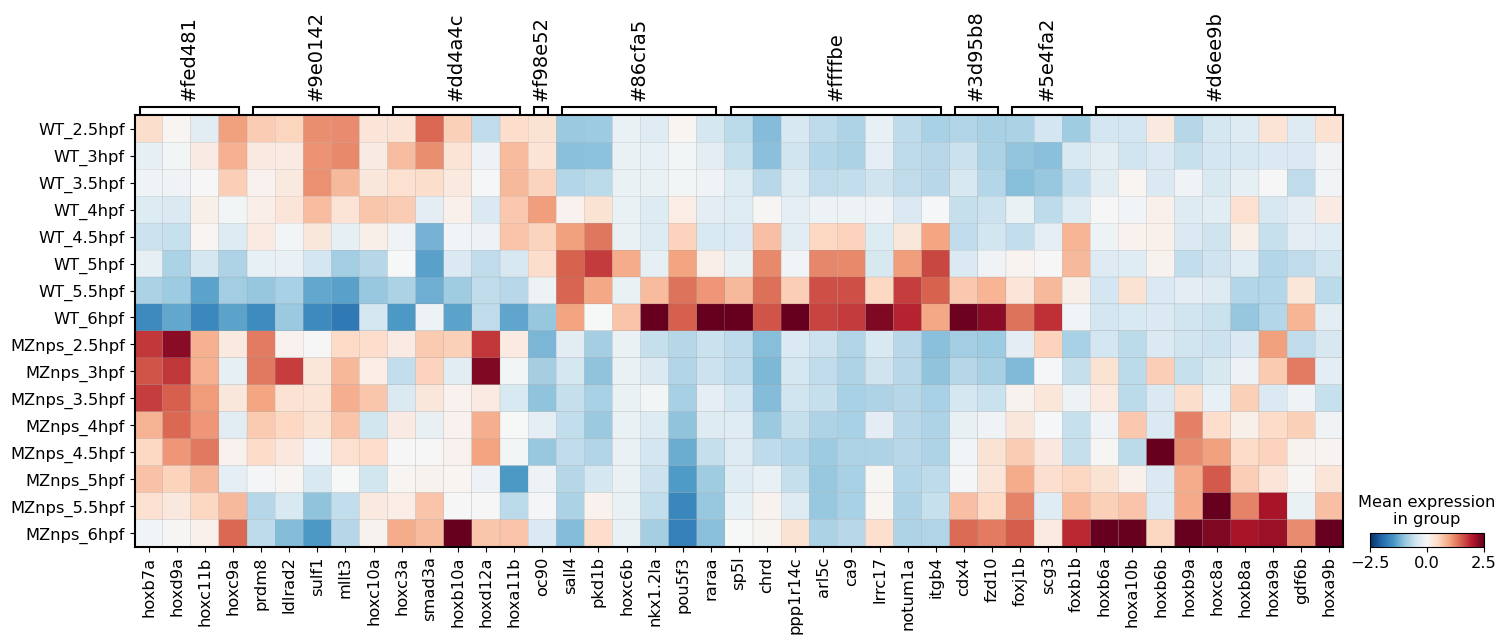

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


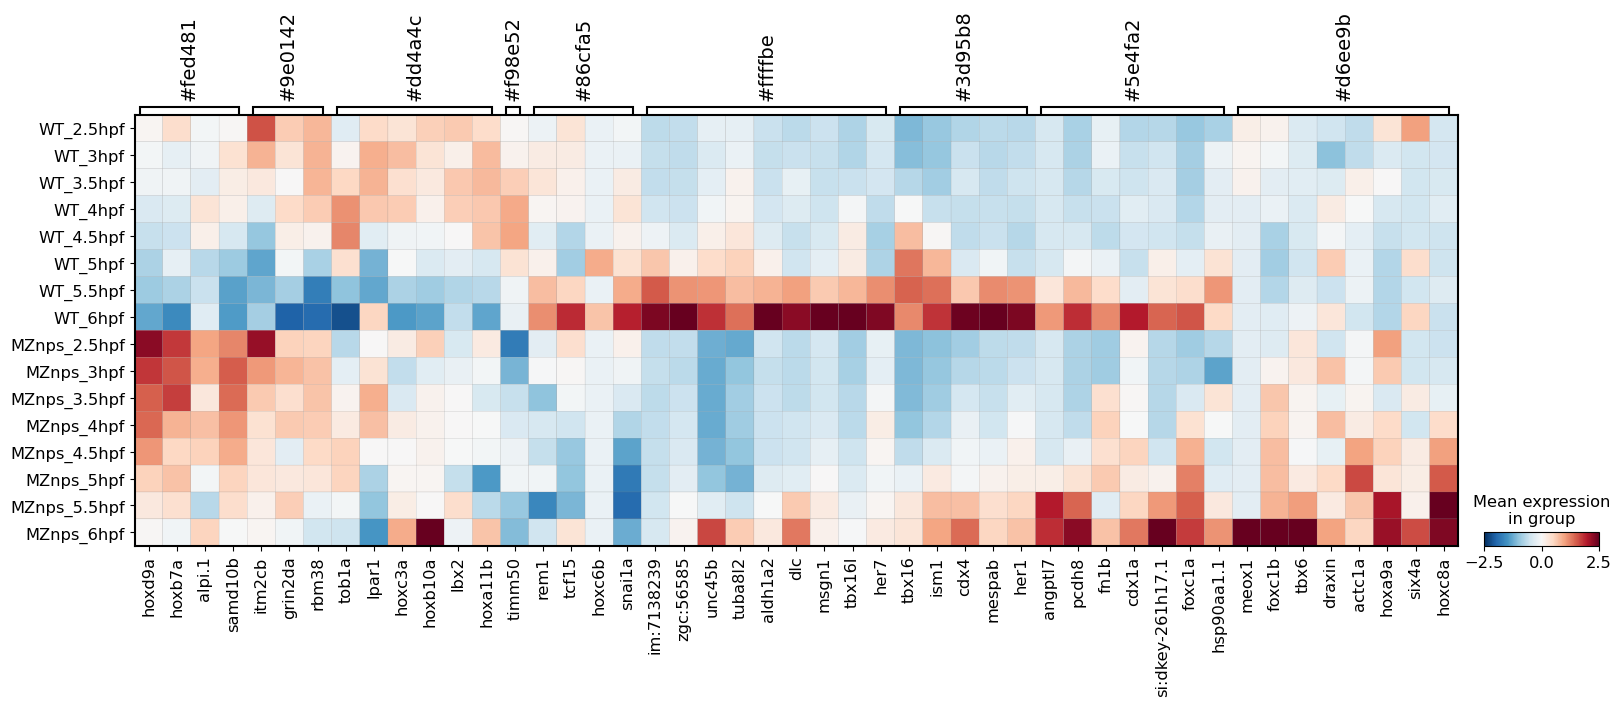

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


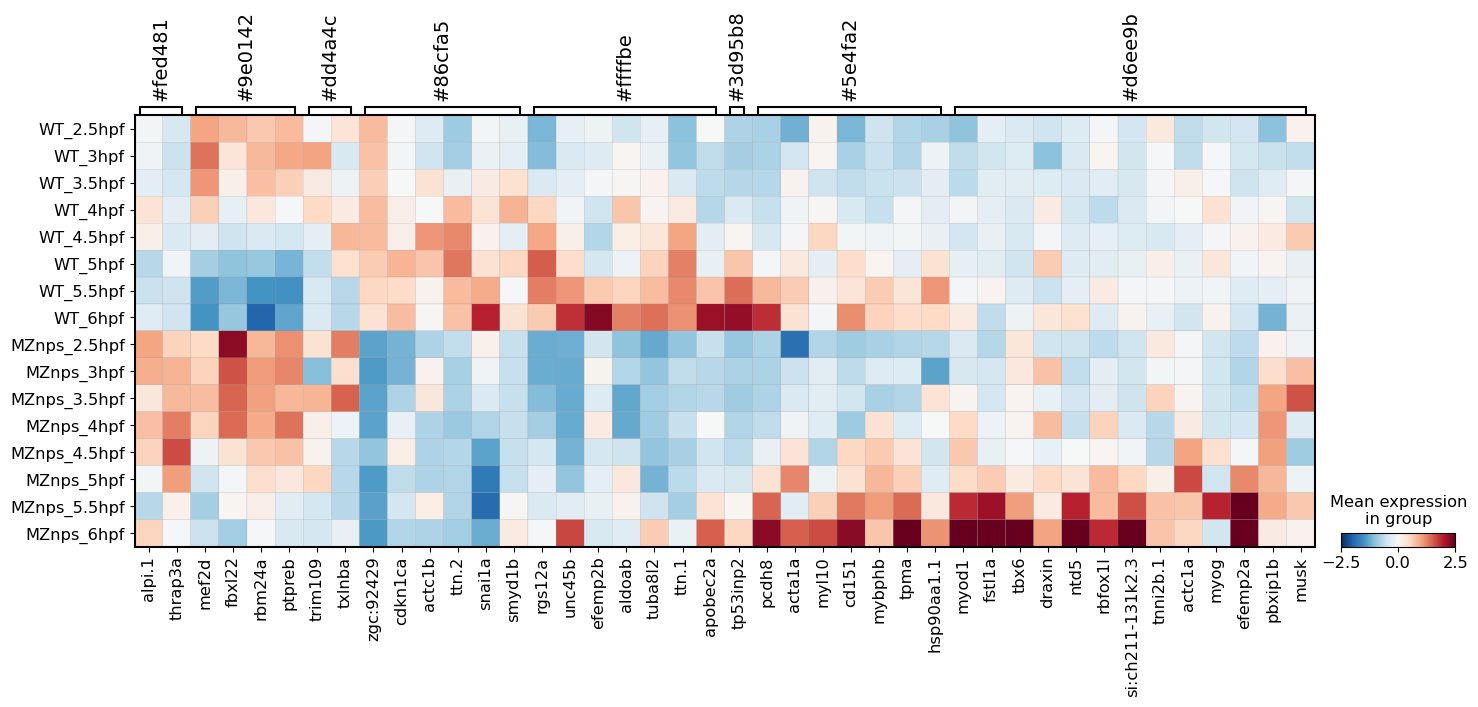

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


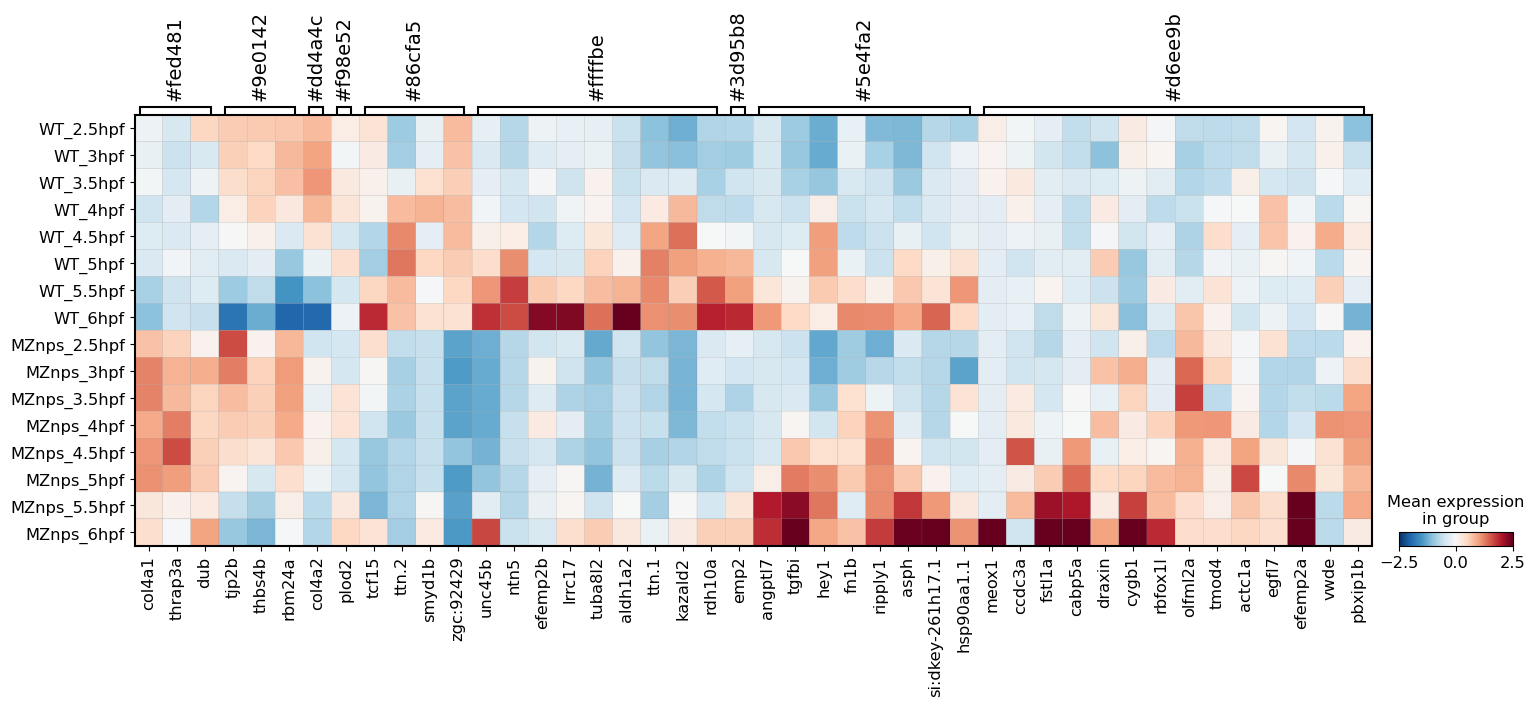

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


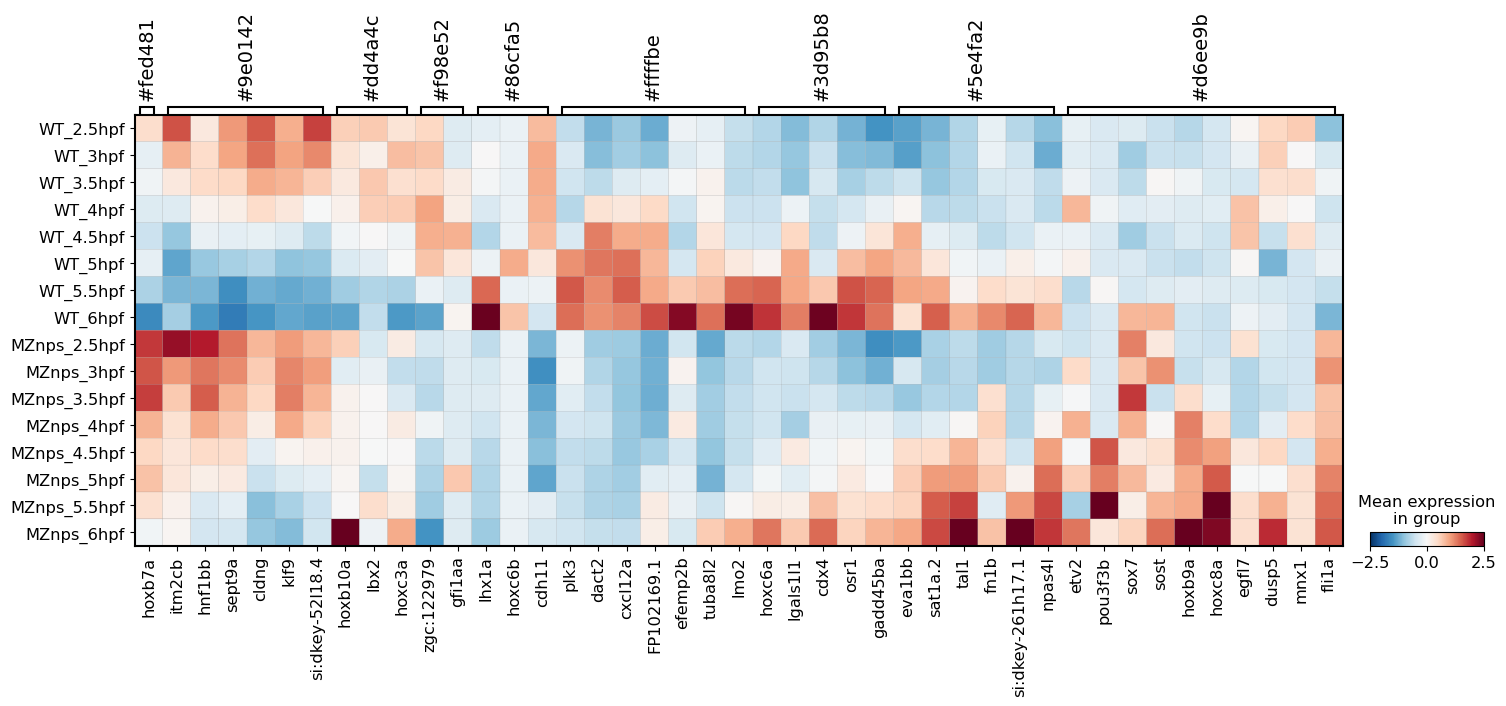

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


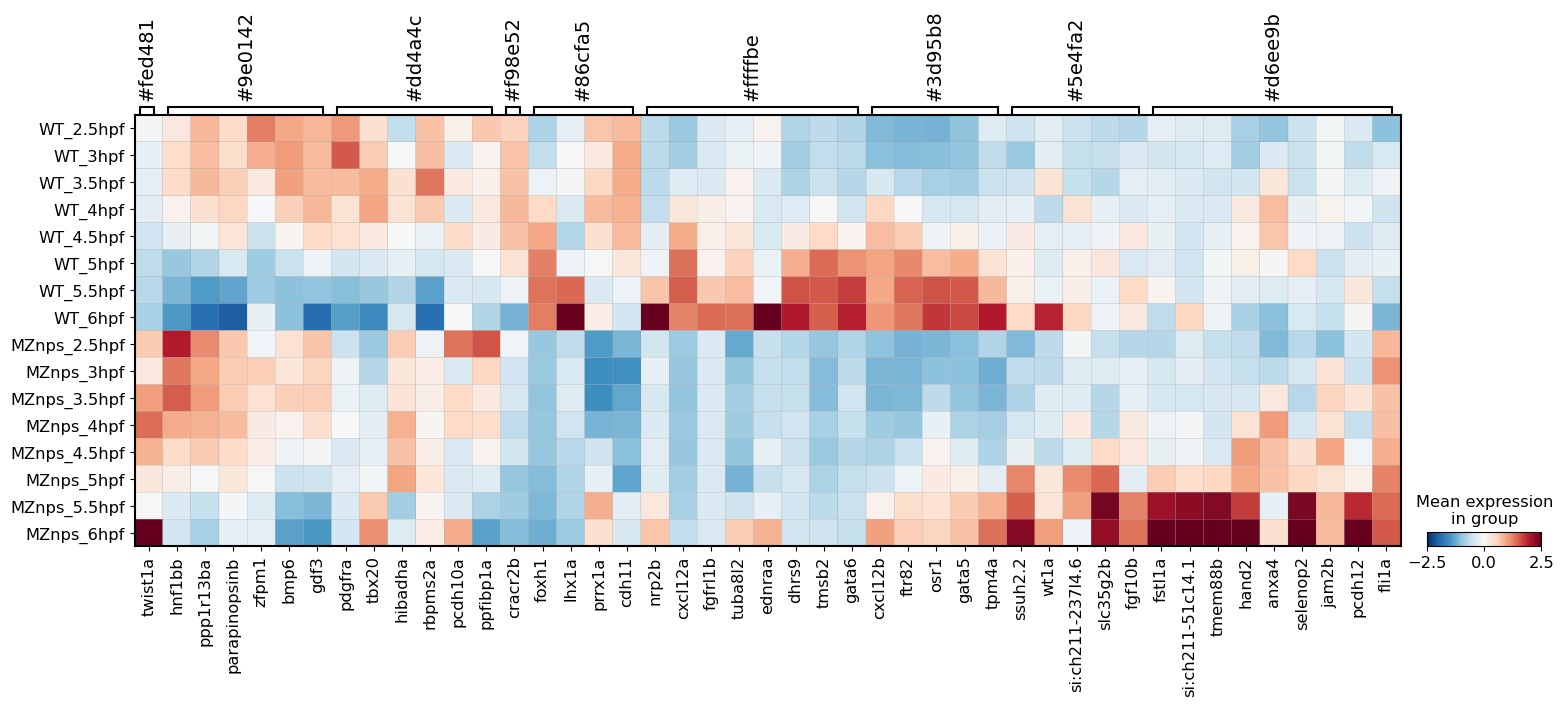

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


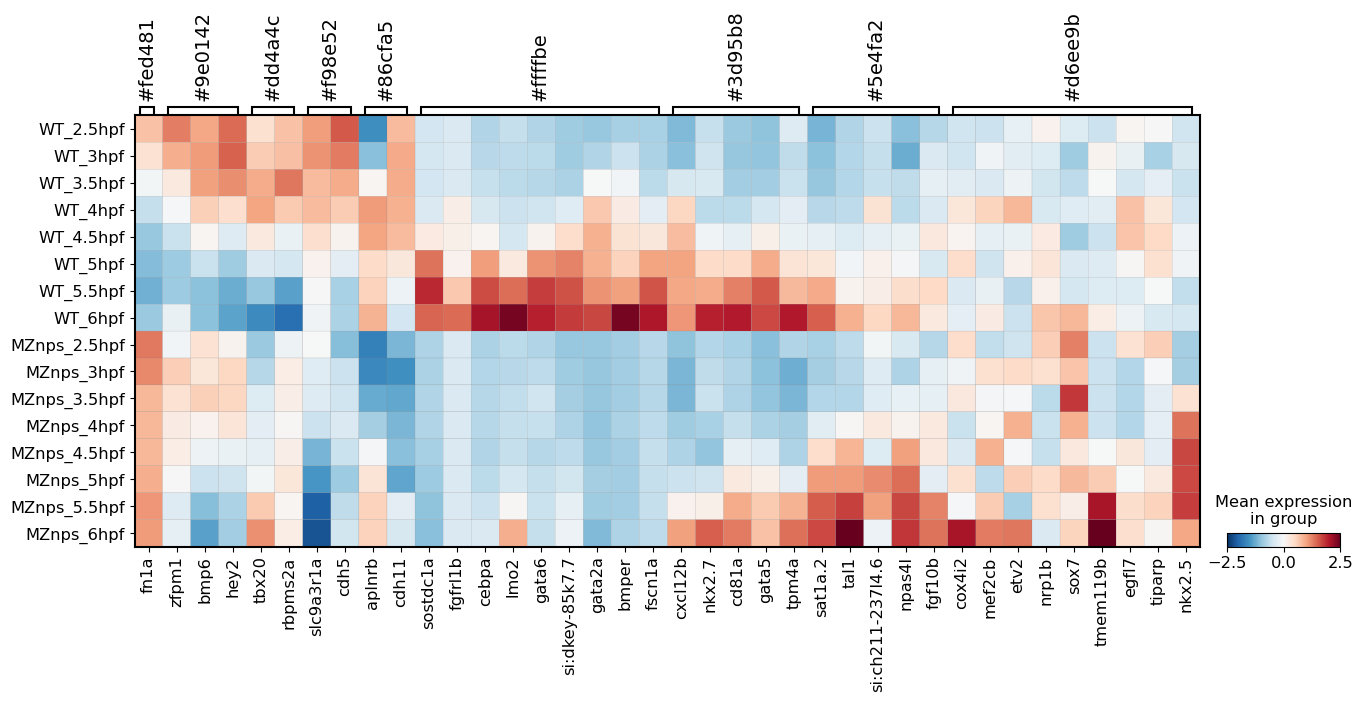

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


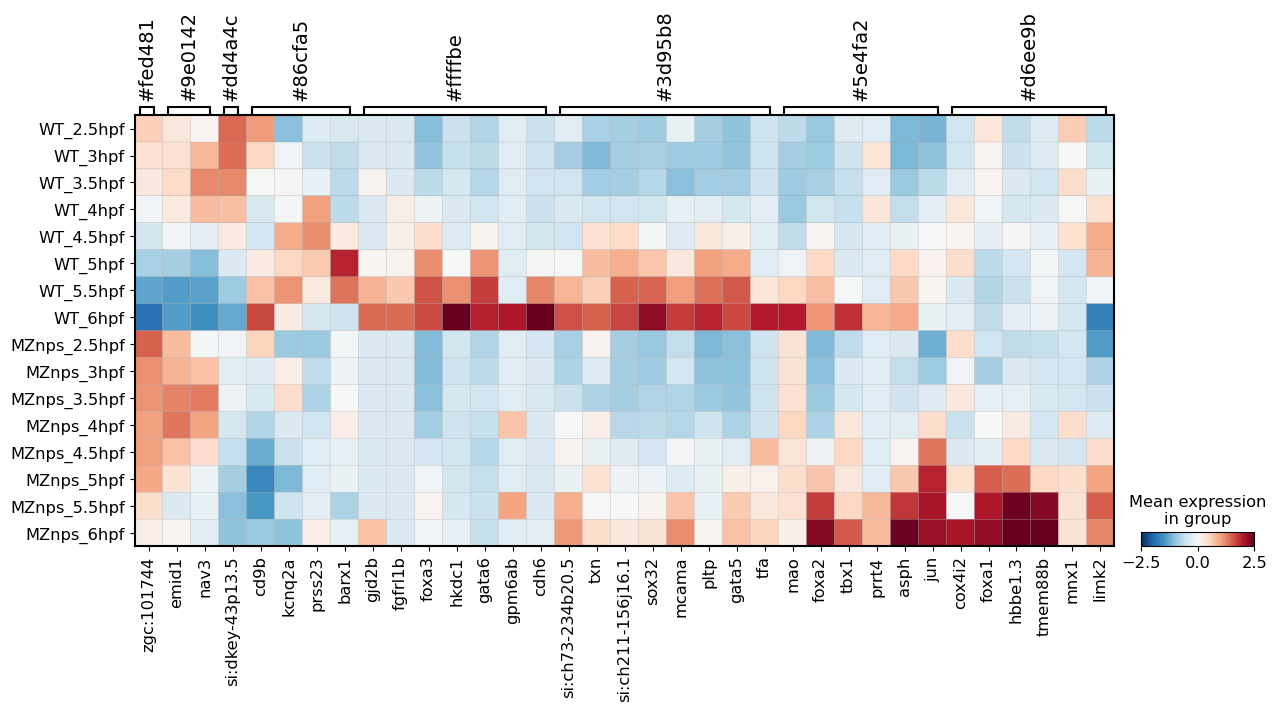

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


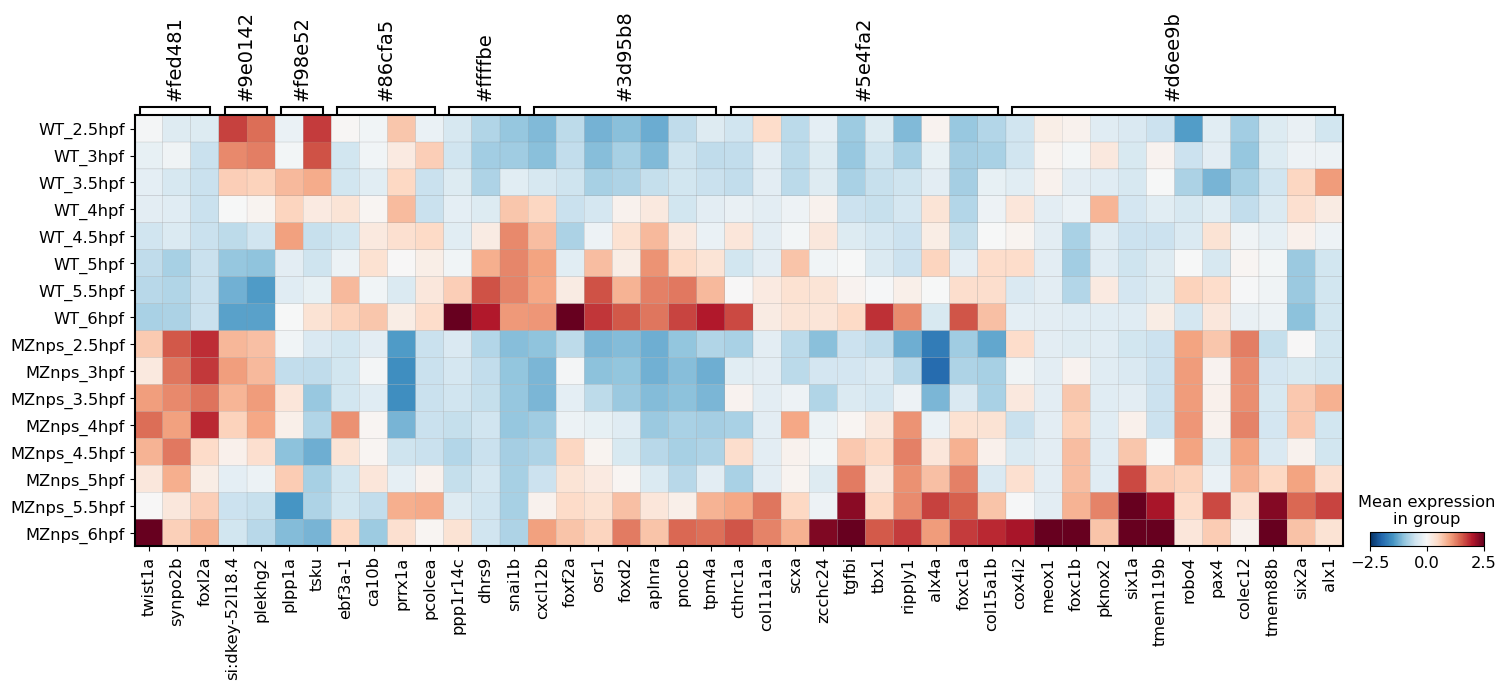

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


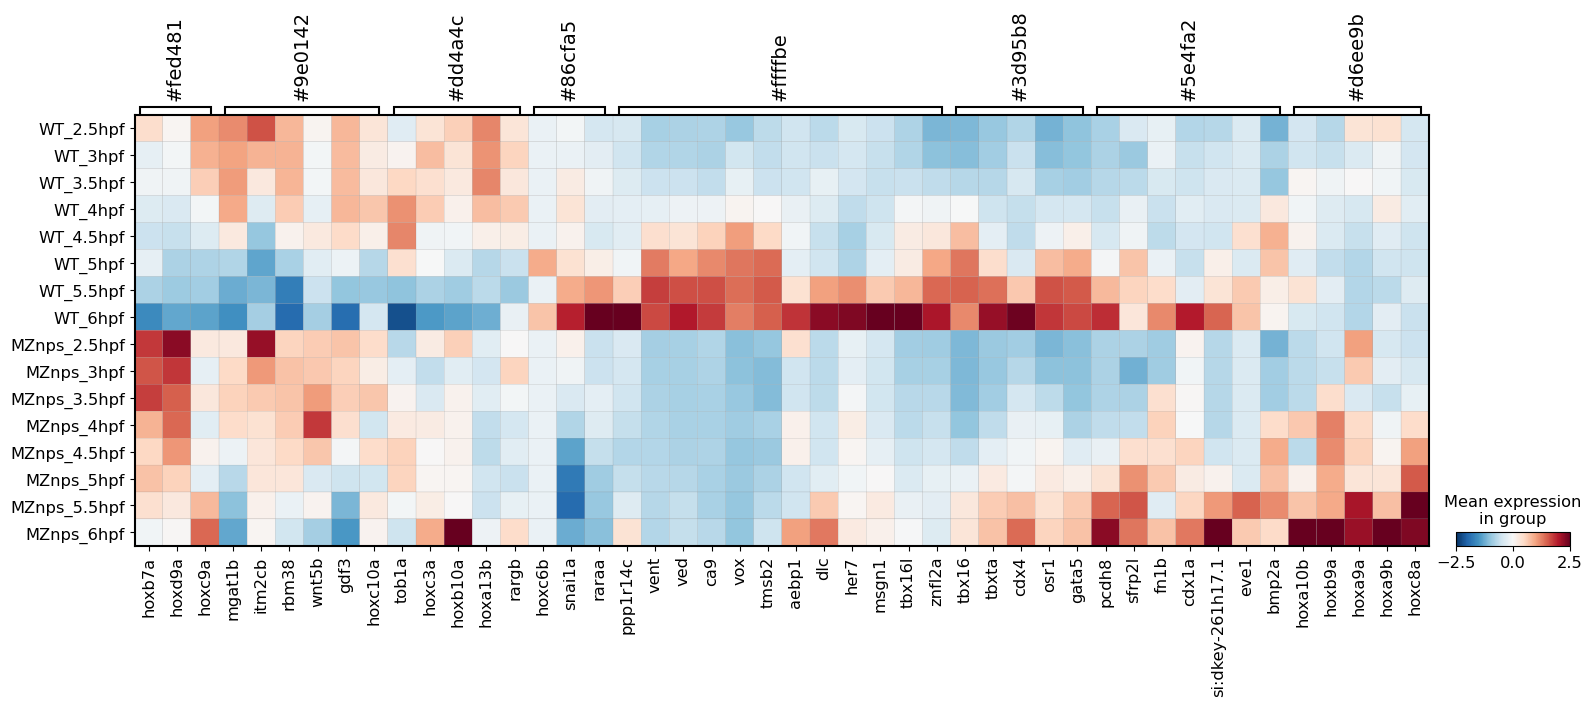

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


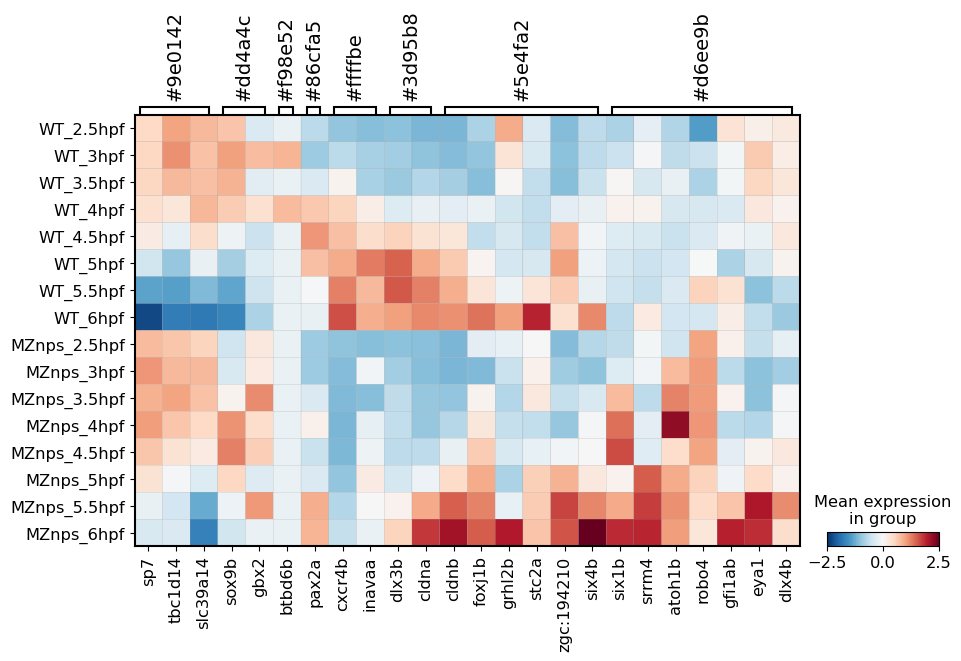

In [45]:
# Create heatmaps per cluster populations
cluster_annotation = cluster_annotation.sort_values(['Cluster', 'Cluster_rho'], ascending=[True, False])

for clust in sdata[sdata.obs.Condition != 'KO'].obs['Tissue_KO_clusters'].cat.categories:

    # Import enrichment data
    tmp = pd.read_csv(f'{syncdir}/Tissue_KO_clusters/Temporal_HVG_cluster_Enrichment_Tissue_KO_clusters_{clust}.csv', index_col=0)
    # tmp = res_comb[res_comb.Cluster == clust]
    if tmp.shape[0] == 0: continue
    
    # Extract genes and order based on rho
    genes_dict = {}
    for i in cluster_order:
        if i not in tmp.Term.to_list(): continue
        genes = str(tmp[tmp.Term == i].reset_index().at[0, 'Genes']).split(";")
        genes_dict[i] = genes
        # # Order based on rho
        # genes_dict[i] = cluster_annotation.iloc[cluster_annotation.index.isin(genes),:].index.to_list()
    
    # Visualise marker expression temporally
    sdata_bulk.obs['Sample_type'] = sdata_bulk.obs['Sample_type'].cat.reorder_categories(['WT_2.5hpf', 'WT_3hpf', 'WT_3.5hpf', 'WT_4hpf', 'WT_4.5hpf', 'WT_5hpf', 'WT_5.5hpf', 'WT_6hpf','MZnps_2.5hpf', 'MZnps_3hpf', 'MZnps_3.5hpf', 'MZnps_4hpf', 'MZnps_4.5hpf', 'MZnps_5hpf', 'MZnps_5.5hpf',  'MZnps_6hpf'])
        
    sc.pl.matrixplot(
        sdata_bulk, 
        genes_dict,  # List of genes to plot
        groupby='Sample_type',  # Grouping by 'Sample_type'
        standard_scale=None,  # No scaling applied
        cmap='RdBu_r',  # Diverging colormap
        layer='X_scaled',  # Use scaled data
        vmin=-2.5,  # Minimum color value
        vmax=2.5,  # Maximum color value
        swap_axes=False,  # Do not swap axes
        # save=f'matrixplot_scMZnps_KO_cluster_{clust}_marker_bulk_timecourse_temporal_colors.pdf'  # Save file
    )


In [46]:
raise SystemExit("Relaxing...")

SystemExit: Relaxing...

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
